# Microsoft Machine Learning Workshop - Timeseries Analysis

The following tutorial will teach the basics of how to work with Timeseries data

The tutorial will cover a range of topics from data analysis, exploration, forecasting, predictions, and neural networks

The tutorial begins with learnignn how to load and explore a timeseries dataset, check that the columns are what we expect, and then perform a decomposition of the timeseries to explore the underlying components:
 - Observed
 - Trend
 - Seasonality
 - Residual
 
Following the exploration of data, we will then learn what it means to stationarise the data, and how to test once differencing has been applied (the method used to stationarise). 
 
Following this, we will explore how a SARIMAX model can be fitted to a simple dataset (of 140 data points), and used for forecasting purposes.

Finally the tutorial will look at alternative methods to model timeseries data, with a quick review of a Recurrent Neural Network, in the shape of a single layer LSTN.
 

## Contents

- #### [Part 0. Load Data](#part_0)
- #### [Part 1. Decomposing - Timeseries Data](#part_1)
- #### [Part 2. Stationarising Timeseries Data](#part_2)
- #### [Part 3. Forecast Modelling - Timeseries Data](#part_3)
- #### [Part 4. Recurrent Neural Networks - Timeseries Forecasting using LSTMs](#part_4)

<a id='part_0'></a>

## Imports and Setup

In [18]:
import pandas as pd
from pandas import Series, DataFrame
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from numpy import log
import numpy as np
import itertools


plt.rcParams['figure.figsize'] = [32, 16] #set the size of the figures 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# code sampples from: 
 # http://dacatay.com/data-science/part-2-time-series-decomposition-python/
 # https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html?highlight=decompose#statsmodels.tsa.seasonal.seasonal_decompose

## The Data

In this example we're going to be using Airline Passenger Information, which contains yearly records of how many passengers travelled on airplanes over several decades

More information on this dataset can be found here: 

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

<a id='part_one'></a>

### Load the Data

In [2]:
series = DataFrame.from_csv('./data/international-airline-passengers.csv', header=0)
series.reset_index(inplace=True)
series['Month'] = pd.to_datetime(series['Month'], format='%Y-%m', errors='coerce')
series = series.set_index('Month')

series.describe()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


144

### Plot Data for Visual Inspection

It's good practice to visually inspect your data before you do anything with it!

Populating the interactive namespace from numpy and matplotlib


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


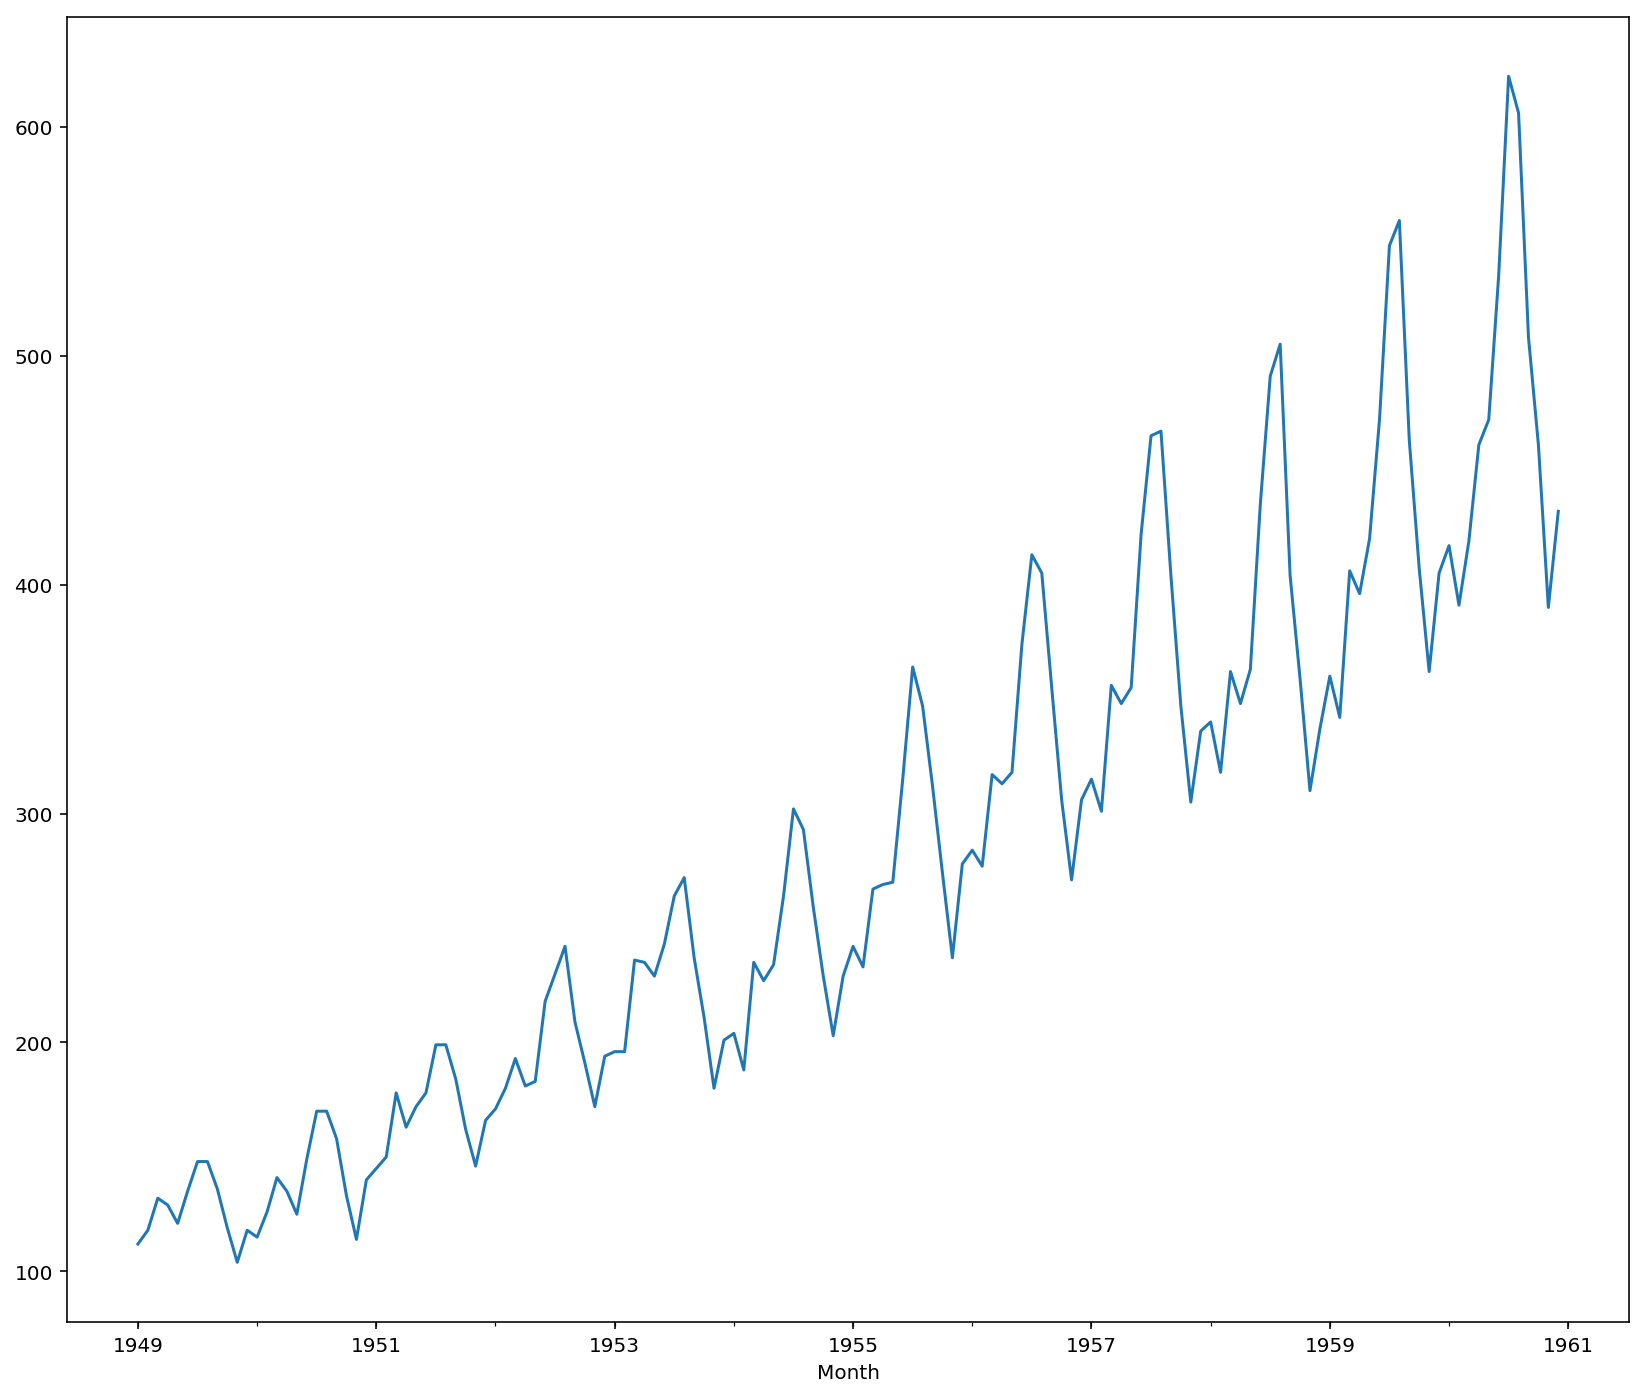

In [42]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 12)

series.Passengers.plot()
plt.show()

<a id='part_1'></a>

# Part 1. Timeseries Decomposition

## Decomposing Timeseries (Manually)

First we are going to manually explore how to decompose the Timeseries manually. To do this, we're going to look at the Trend followed by the Seasonality components.

The fundamental idea of time series decomposition (and ultimately time series analysis) is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

 - Trend – overall direction of the series i.e. upwards, downwards etc
 - Seasonality – monthly or yearly patterns
 - Cycle – long-term business cycles, they usually come after 5 or 7 years
 - Noise – irregular remainder left after extraction of all the components


### Trend

Let's first explore how to expose the trend using the moving average method

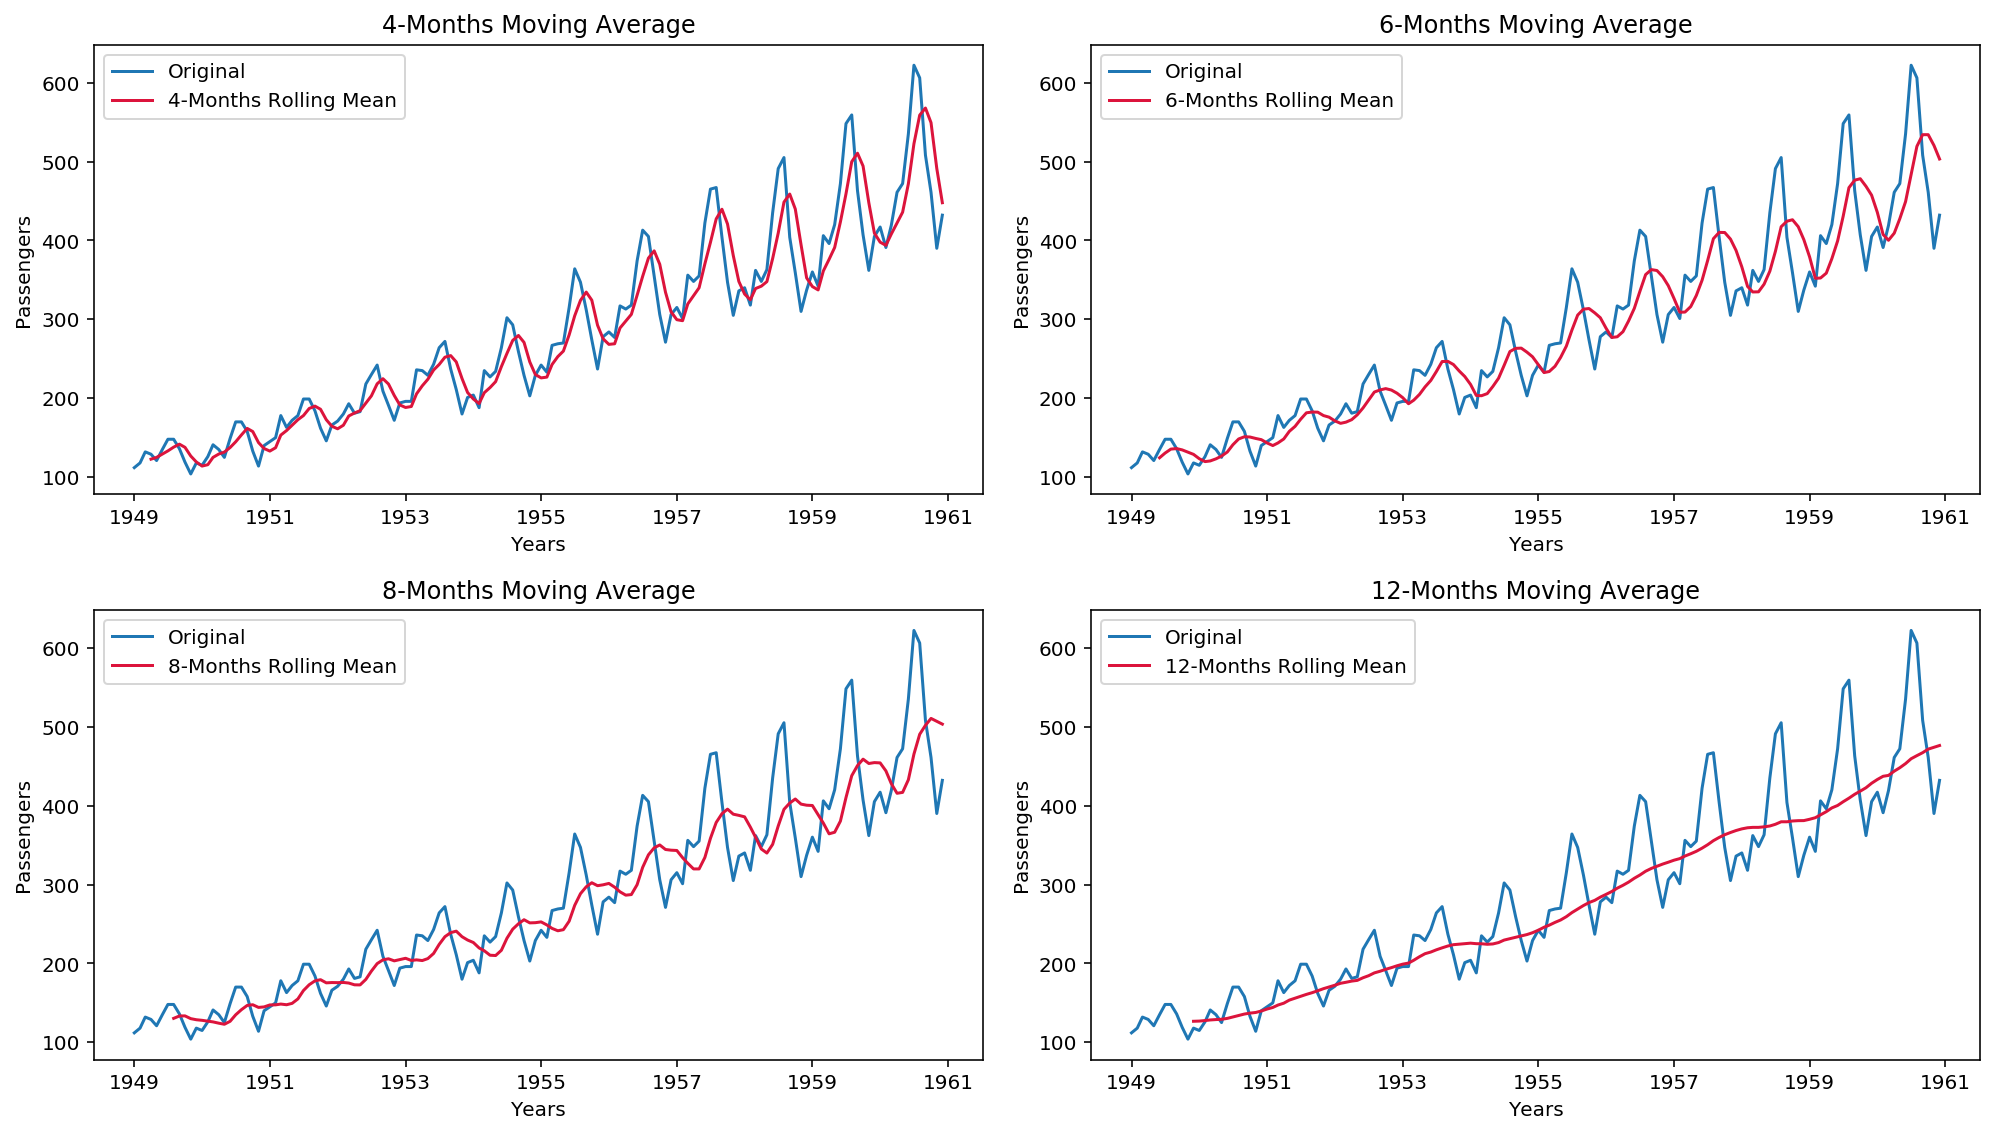

In [22]:
y = series['Passengers']

# define figure and axes
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False);
fig.set_figwidth(14);
fig.set_figheight(8);
 
# push data to each ax
#upper left
axes[0][0].plot(y.index, y, label='Original');
axes[0][0].plot(y.index, y.rolling(window=4).mean(), label='4-Months Rolling Mean', color='crimson');
axes[0][0].set_xlabel("Years");
axes[0][0].set_ylabel("Passengers");
axes[0][0].set_title("4-Months Moving Average");
axes[0][0].legend(loc='best');
 
# upper right
axes[0][1].plot(y.index, y, label='Original')
axes[0][1].plot(y.index, y.rolling(window=6).mean(), label='6-Months Rolling Mean', color='crimson');
axes[0][1].set_xlabel("Years");
axes[0][1].set_ylabel("Passengers");
axes[0][1].set_title("6-Months Moving Average");
axes[0][1].legend(loc='best');
 
# lower left
axes[1][0].plot(y.index, y, label='Original');
axes[1][0].plot(y.index, y.rolling(window=8).mean(), label='8-Months Rolling Mean', color='crimson');
axes[1][0].set_xlabel("Years");
axes[1][0].set_ylabel("Passengers");
axes[1][0].set_title("8-Months Moving Average");
axes[1][0].legend(loc='best');
 
# lower right
axes[1][1].plot(y.index, y, label='Original');
axes[1][1].plot(y.index, y.rolling(window=12).mean(), label='12-Months Rolling Mean', color='crimson');
axes[1][1].set_xlabel("Years");
axes[1][1].set_ylabel("Passengers");
axes[1][1].set_title("12-Months Moving Average");
axes[1][1].legend(loc='best');
plt.tight_layout();
plt.show()

### Adding Moving Mean and Moving Standard Deviation

Populating the interactive namespace from numpy and matplotlib


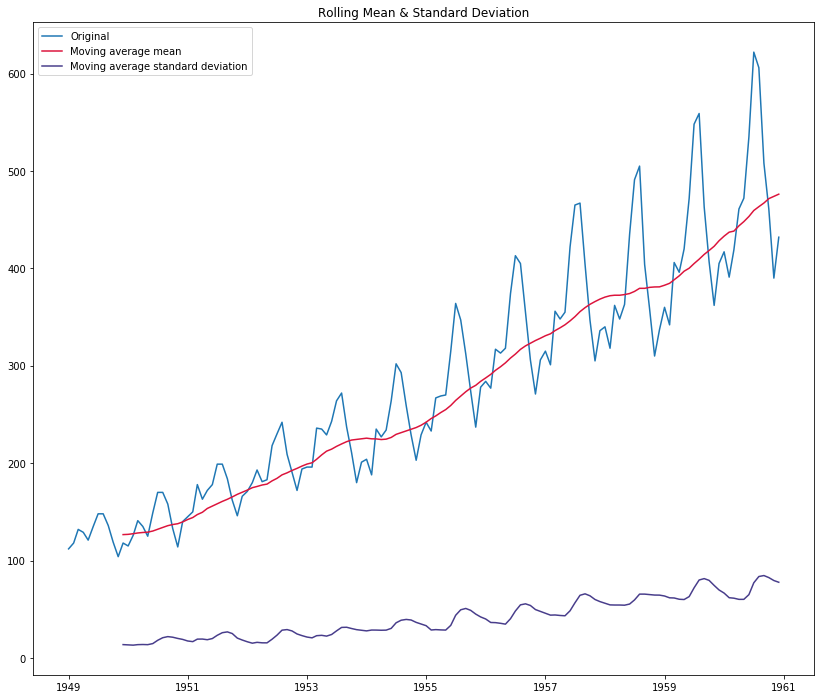

In [30]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 12)

def plot_rolling_average(y, window=12):
    '''
    Plot rolling mean and rolling standard deviation for a given time series and window
    '''
    # calculate moving averages
    rolling_mean = y.rolling(window).mean()
    rolling_std = y.rolling(window).std()
 
    # plot statistics
    plt.plot(y, label='Original')
    plt.plot(rolling_mean, color='crimson', label='Moving average mean')
    plt.plot(rolling_std, color='darkslateblue', label='Moving average standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    return
 
# use the function
plot_rolling_average(y)

### Seasonality

We can check this hypothesis of a seasonal effect by pivoting our data for years and months and then check for the distribution of passengers. A yearly line plot can be implemented as follows



Populating the interactive namespace from numpy and matplotlib


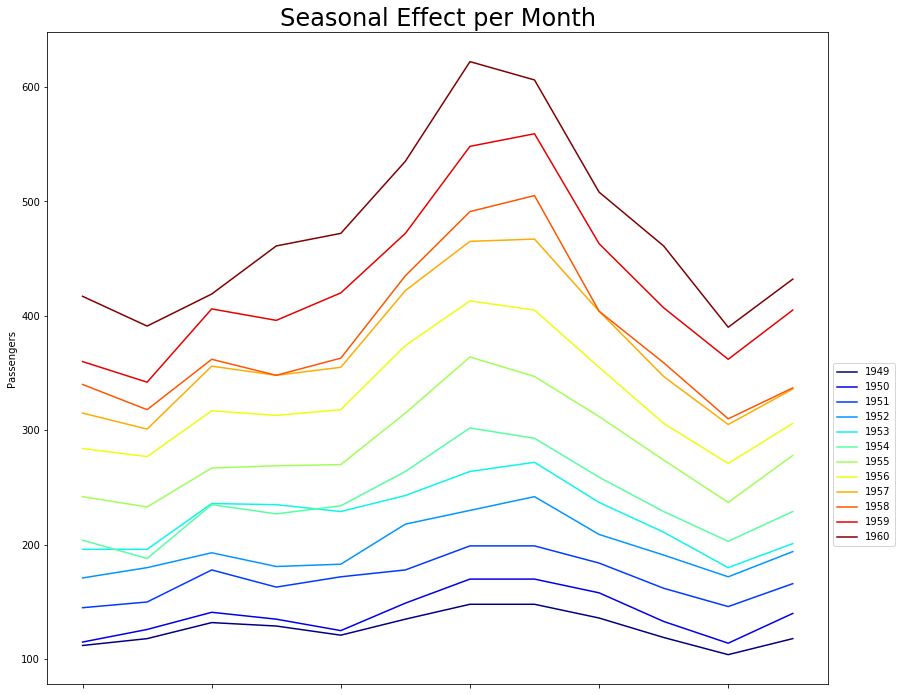

In [31]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 12)

df = series

window = 12

# create new columns to DataFrame by extracting a string representing 
# the time under the control of an explicit format string
df['Month'] = df.index.strftime('%b') # '%b' extracts the month in locale's abbreviated name from the index
df['Year'] = df.index.year

# create nice axes names
month_names = pd.date_range(start='1949-01-01', periods=window, freq='MS').strftime('%b')

# reshape data using 'Year' as index and 'Month' as column
df_piv_line = df.pivot(index='Month', columns='Year', values='Passengers')
df_piv_line = df_piv_line.reindex(index=month_names)

# create line plot
df_piv_line.plot(colormap='jet')
plt.title('Seasonal Effect per Month', fontsize=24)
plt.ylabel('Passengers')
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))

plt.show()  


For the summer months we notice the highest numbers of airline passengers. We can also create a box plot which will indicate the distribution of passengers over the months.

Populating the interactive namespace from numpy and matplotlib


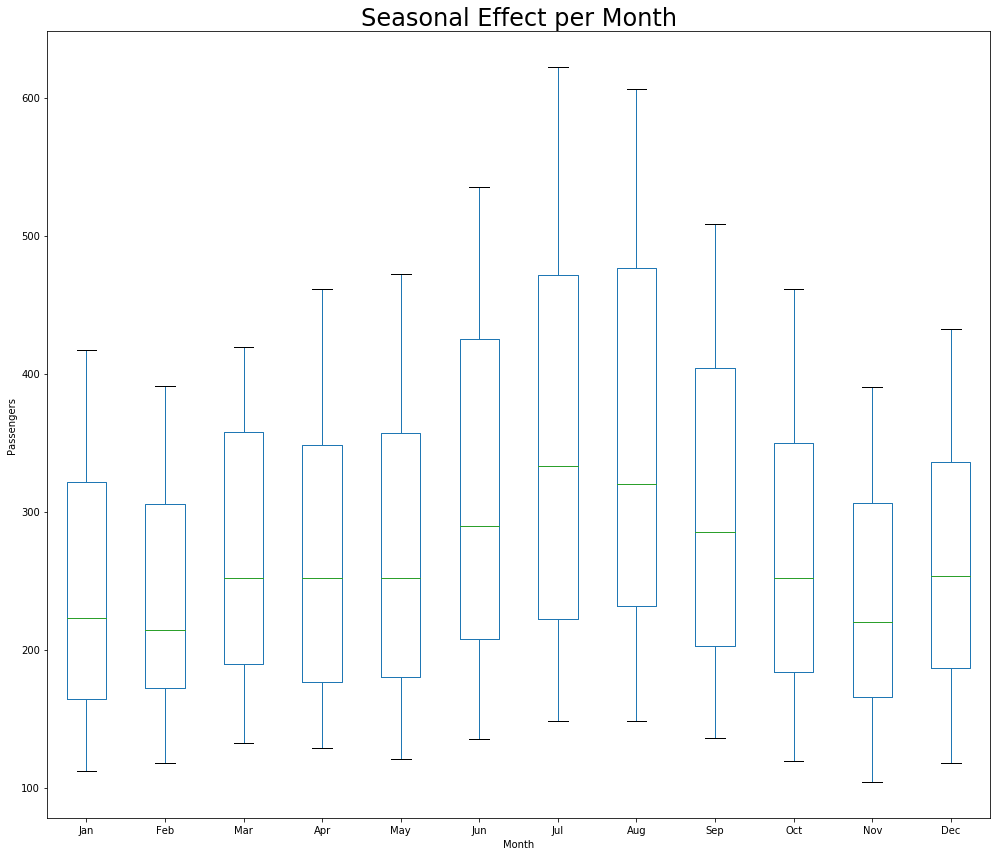

In [32]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 12)

df = series

df['Month'] = df.index.strftime('%b')
df['Year'] = df.index.year
 
# create nice axes names
month_names = pd.date_range(start='1949-01-01', periods=12, freq='MS').strftime('%b')
 
# reshape date
df_piv_box = df.pivot(index='Year', columns='Month', values='Passengers')
 
# reindex pivot table with 'month_names'
df_piv_box = df_piv_box.reindex(columns=month_names)
 
# create a box plot
fig, ax = plt.subplots();
#plt.figure(figsize=(16,12));
df_piv_box.plot(ax=ax, kind='box');
ax.set_title('Seasonal Effect per Month', fontsize=24);
ax.set_xlabel('Month');
ax.set_ylabel('Passengers');
ax.xaxis.set_ticks_position('bottom');
fig.tight_layout();
plt.show()

We can see that July and August are the peak months for airline passengers and the variance and the mean for these months are also much higher than any of the other months. 

A seasonal cycle of 12 months can be observed, where the mean value of each month starts with an increasing trend in the beginning of the year and drops down toward the end of the year.

This confirms our hypothesis and as we have expected there is a prevalent tendency of using more aircrafts during the summer months.

## Decomposing Timeseries (Using StatsModel)

Now Use the StatsModel's Seasonal Decompose to view the different underlying components of the tiimeseries.

Notes on Seasonal Decompose:

This is a naive decomposition. More sophisticated methods should be preferred.

 - The additive model is Y[t] = T[t] + S[t] + e[t]

 - The multiplicative model is Y[t] = T[t] * S[t] * e[t]
 
 
 e.g. 

1. Additive:  xt = Trend + Seasonal + Random

2. Multiplicative:  xt = Trend * Seasonal * Random

The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each period is the returned seasonal component.

How to Choose Between Additive and Multiplicative Decompositions

- The additive model is useful when the seasonal variation is relatively constant over time.
- The multiplicative model is useful when the seasonal variation increases over time.


### Multiplicative Decompose

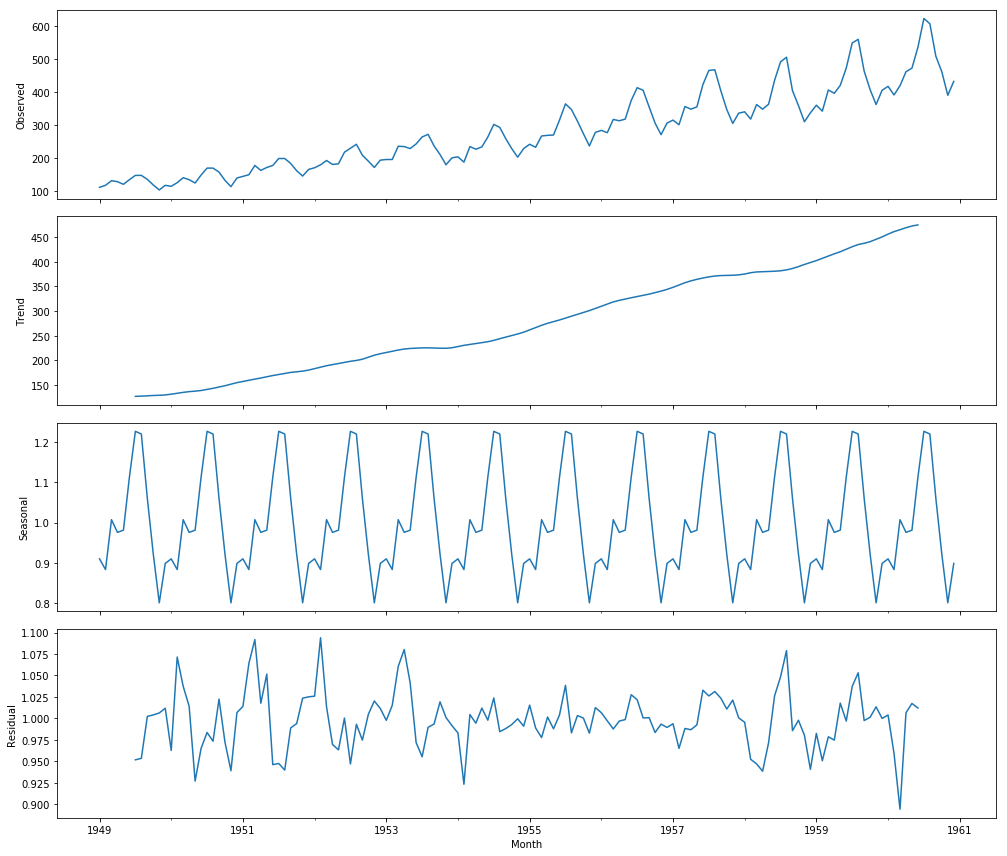

In [33]:
result = seasonal_decompose(series.Passengers, model='multiplicative')
result.plot()

pyplot.show()

### Additive Decompose

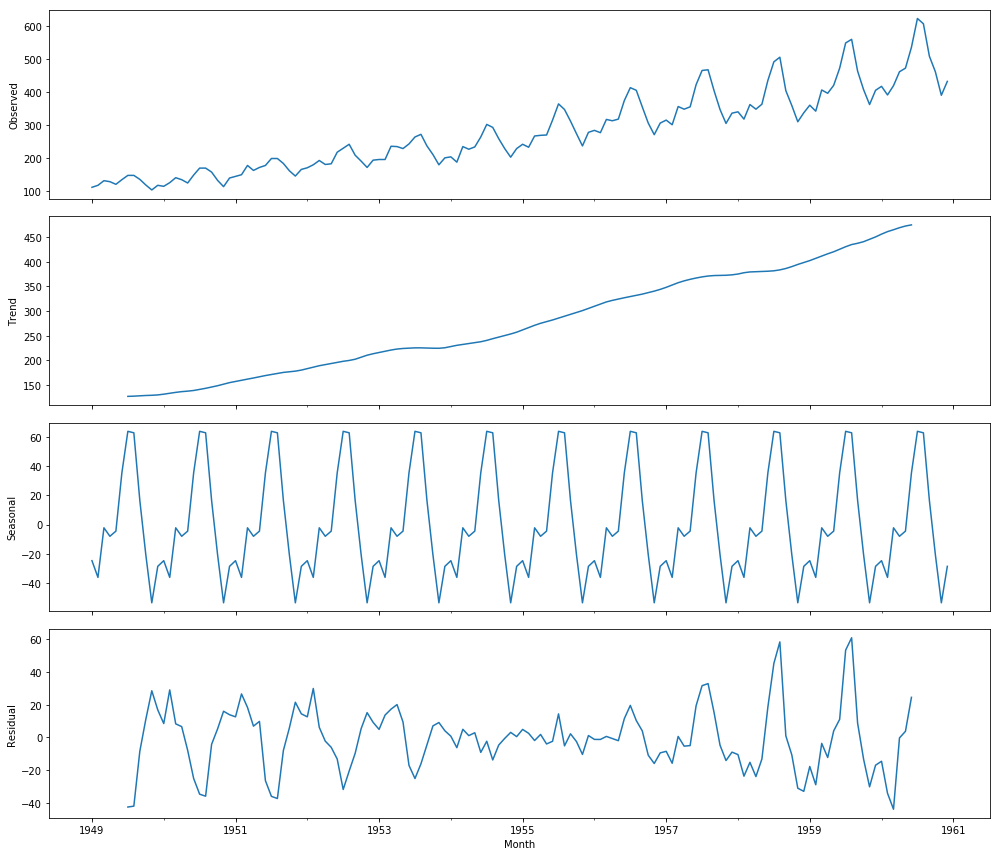

In [34]:
result = seasonal_decompose(series.Passengers, model='additive')
result.plot()
pyplot.show()

### Comparing Additive and Multiplicative

Note the differences in the scale of the decomposed time series when compared to the multiplicative model. There is still a pattern left in the residual series. The high residual values of the additive decomposition indicate that the application of a multiplicative model is preferable. 

When the data contains negative values, e.g. a data series on average monthly temperatures, an additive model should be used.



<a id='part_2'></a>

# Part 2. Stationarising Timeseries Data

The observations in a stationary time series are not dependent on time.

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.

**Checks for Stationarity**

There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

 - Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
 - Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
 - Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

### Distribution Plot

First lets take a look at the distribution of the data, we're expecting a Gaussian distribution (e.g. Normal)

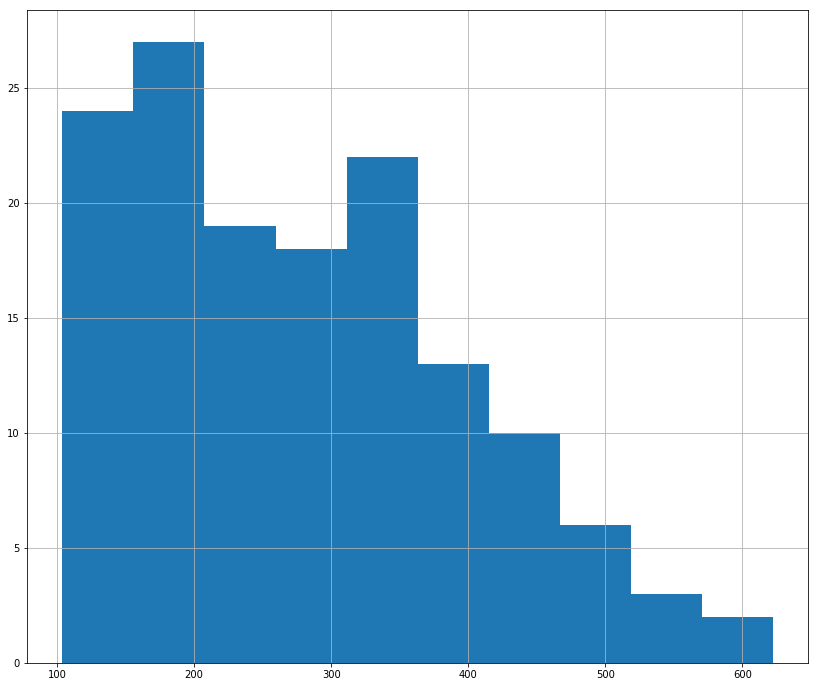

In [36]:
series.Passengers.hist()
plt.show()

### Summary Statistics

Next let's do a quick check on the Mean and Variance of the dataset at different points in time. 

Remmeber if the data is stationary, the mean and variance (and autocorrelation) should remain constant throuhgout

In [37]:
X = series.Passengers.values
split = int(len(X) / 2)

X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=182.902778, mean2=377.694444
variance1=2244.087770, variance2=7367.962191


We can see that the mean values at different points in the data (we made two time windows) is different, as is the variance. This is a potential indicator that the data is not stationary.

**Check for Exponetial Component**

However, we notice that the non-Gaussian Distribution may show some expoential growth in the data (e.g per year more people fly), so we also want to check if the Logarithmic of the number of passengers is Guaissian.

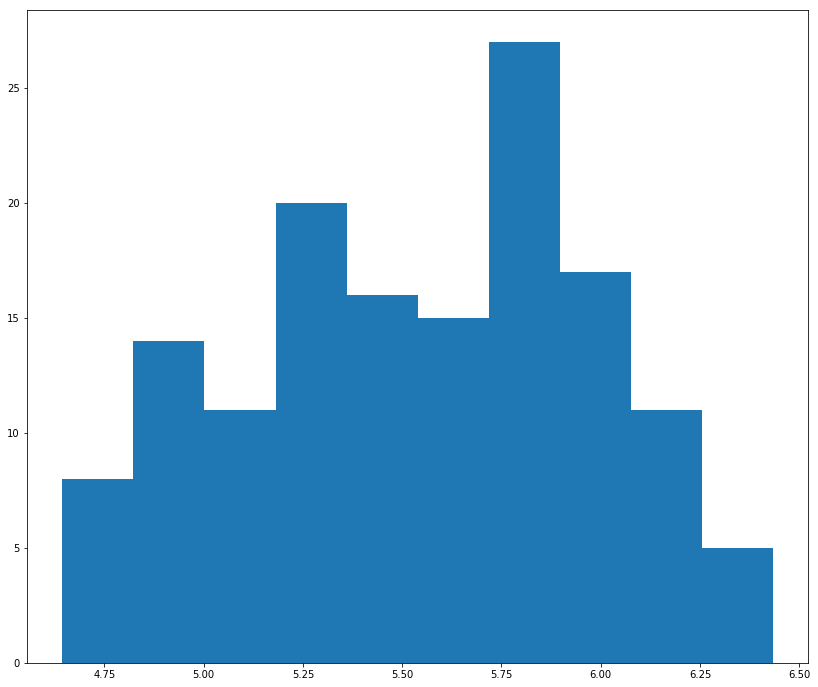

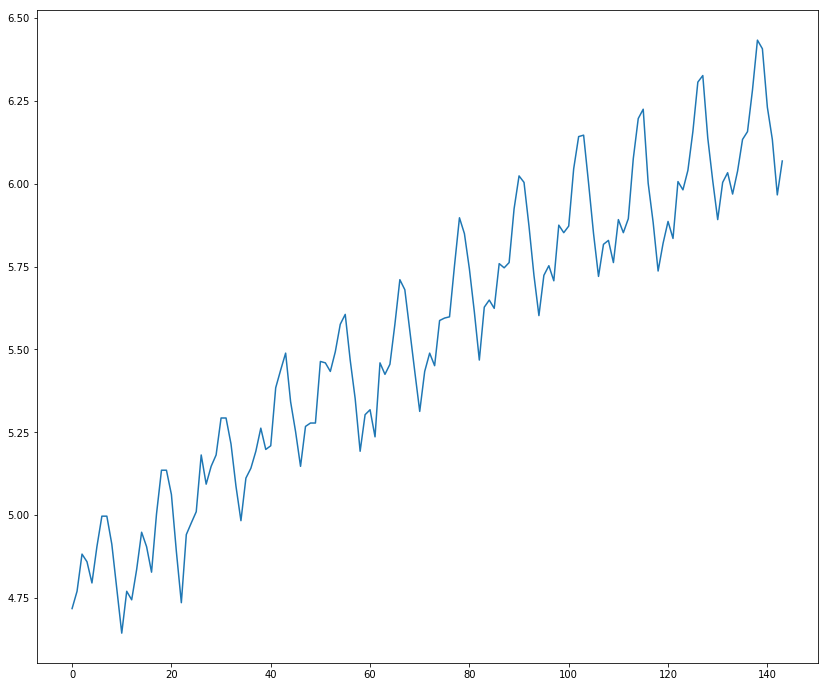

mean1=5.175146, mean2=5.909206
variance1=0.068375, variance2=0.049264


In [38]:
X = series.Passengers.values

X = log(X)
pyplot.hist(X)
pyplot.show()
pyplot.plot(X)
pyplot.show()

split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

**Result:**  

Whilst the above show that the means and variance look similar (but not the same), it would still be wise to assume that the data is not stationary

Instead of attempting to expose the stationarity of the data via distributions, means, and variance over a time window, using unit root tests would be advisable.


## Unit Root Test

A unit root test tests whether a time series variable is non-stationary and possesses a unit root. The null hypothesis is generally defined as the presence of a unit root and the alternative hypothesis is either stationarity, trend stationarity or explosive root depending on the test used.


### Augmented Dickey-Fuller test
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

** adfuller() Method:**

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

The autolag option and maxlag for it are described in Greene.

**Interpretting the ADF Statistic:** 

 - Given a negative ADF statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

- The null hypothesis for this test is that there is a unit root.
- The alternate hypothesis differs slightly according to which equation you’re using. The basic alternate is that the time series is stationary (or trend-stationary).


As part of the output, we get a look-up table to help determine the ADF statistic. 

**Result:**
The test statistic is positive, meaning we are much less likely to reject the null hypothesis (it looks non-stationary).

Comparing the test statistic to the critical values, it looks like we would have to fail to reject the null hypothesis that the time series is non-stationary and does have time-dependent structure.

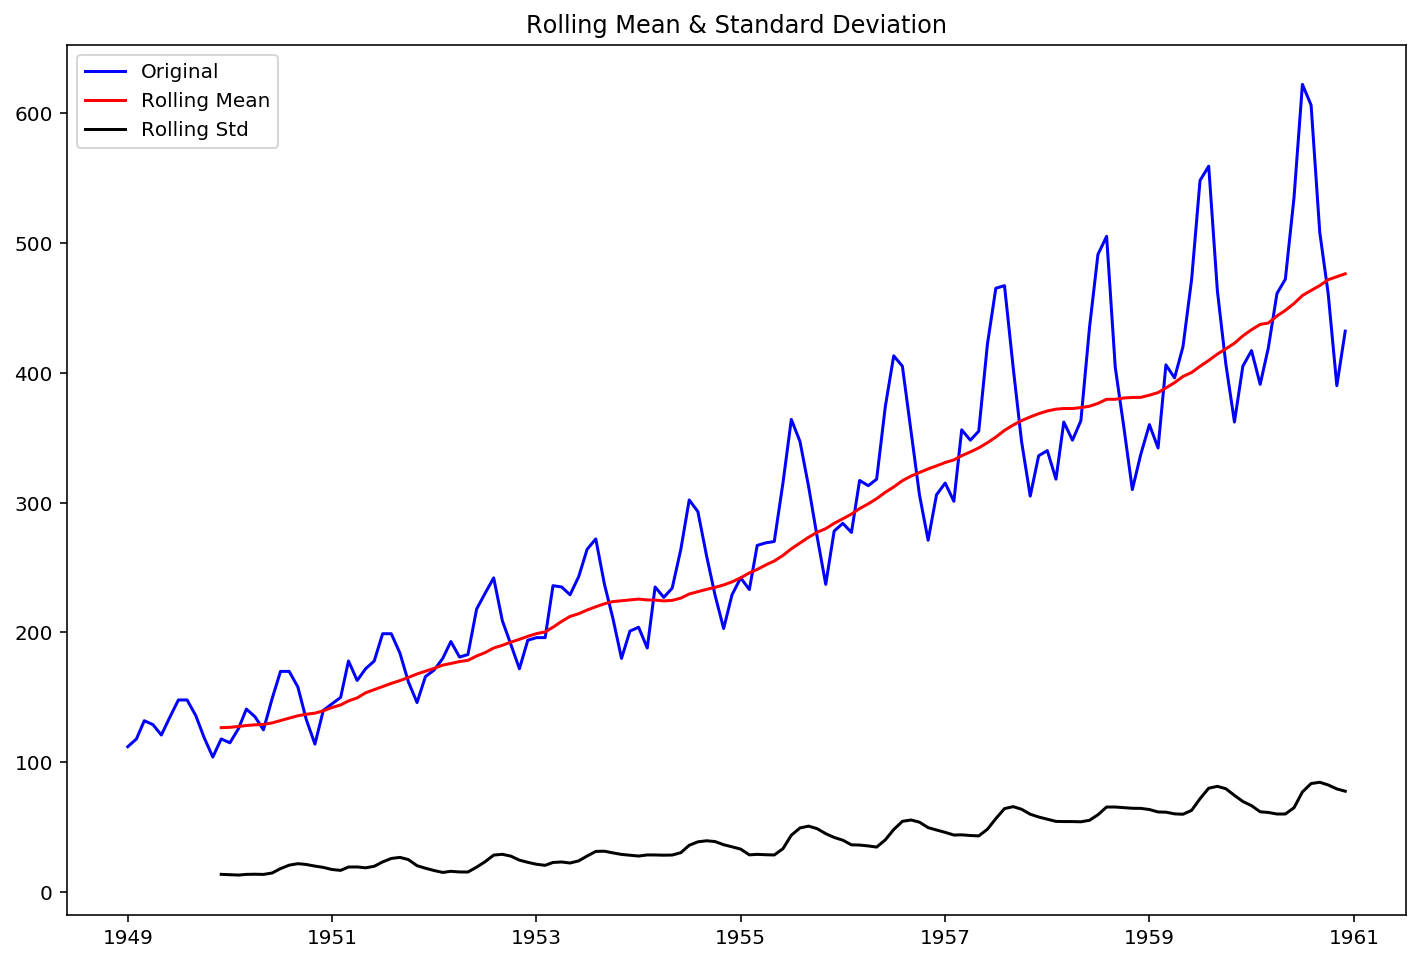

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [26]:
#thanks Salim for the nice method:)
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, is_log=False):
    
    # original code and kudos to Sean Abu
    # https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    
    X = timeseries.values
    if is_log:
        X = log(X)
    
    dftest = adfuller(X, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(series.Passengers)

## Differencing the Timeseries Dataset

If the dataset appears to be non-stationary, then we need to apply differencing in order to ensure we obtain a stationary dataset before using it for analysis.

**Differencing Approaches:**
 - Deflation by CPI
 - Logarithmic
 - First Difference
 - Seasonal Difference
 - Seasonal Adjustment

** Method: **

Differencing is performed by subtracting the previous observation from the current observation.

 - difference(t) = observation(t) - observation(t-1)
 
** Remember ** 

Inverting the process is required when a prediction must be converted back into the original scale.

This process can be reversed by adding the observation at the prior time step to the difference value.

 - inverted(t) = differenced(t) + observation(t-1)


### Differencing

In [24]:
def apply_differencing(ts, series, method):
    print('Stationarise data using: {}'.format(series + '_'+ method))

    if method is 'log' :    
        ts[series+'_log']= ts[series].apply(lambda x: np.log(x))          

    elif method is 'first_difference' :
        ts[series+'_first_difference'] = ts[series] - ts[series].shift(1)      

    elif method is 'log_first_difference' :
        ts[series +'_log'] = ts[series].apply(lambda x: np.log(x))  
        ts[series+'_log_first_difference'] = ts[series+'_log'] - ts[series].shift(1)      

    elif method is 'seasonal_difference' :
        ts[series+'_seasonal_difference'] = ts[series] - ts[series].shift(12)      

    elif method is 'log_seasonal_difference' :
        ts[series+'_log']= ts[series].apply(lambda x: np.log(x))  
        ts[series+'_log_seasonal_difference'] = ts[series+'_log'] - ts[series+'_log'].shift(12)      

    elif method is 'seasonal_first_difference' :
        ts[series+'_first_difference'] = ts[series] - ts[series].shift(1)  
        ts[series+'_seasonal_first_difference'] = \
            ts[series+'_first_difference'] - ts[series+'_first_difference'].shift(12)      

    elif method is 'log_seasonal_first_difference' :
        ts[series+'_log'] = ts[series].apply(lambda x: np.log(x))  
        ts[series+'_log_first_difference'] = ts[series+'_log'] - ts[series+'_log'].shift(1)  
        ts[series+'_log_seasonal_first_difference'] = \
            ts[series+'_log_first_difference'] - ts[series+'_log_first_difference'].shift(12)
    
    return series + '_'+ method


Stationarise data using: Passengers_log_seasonal_first_difference


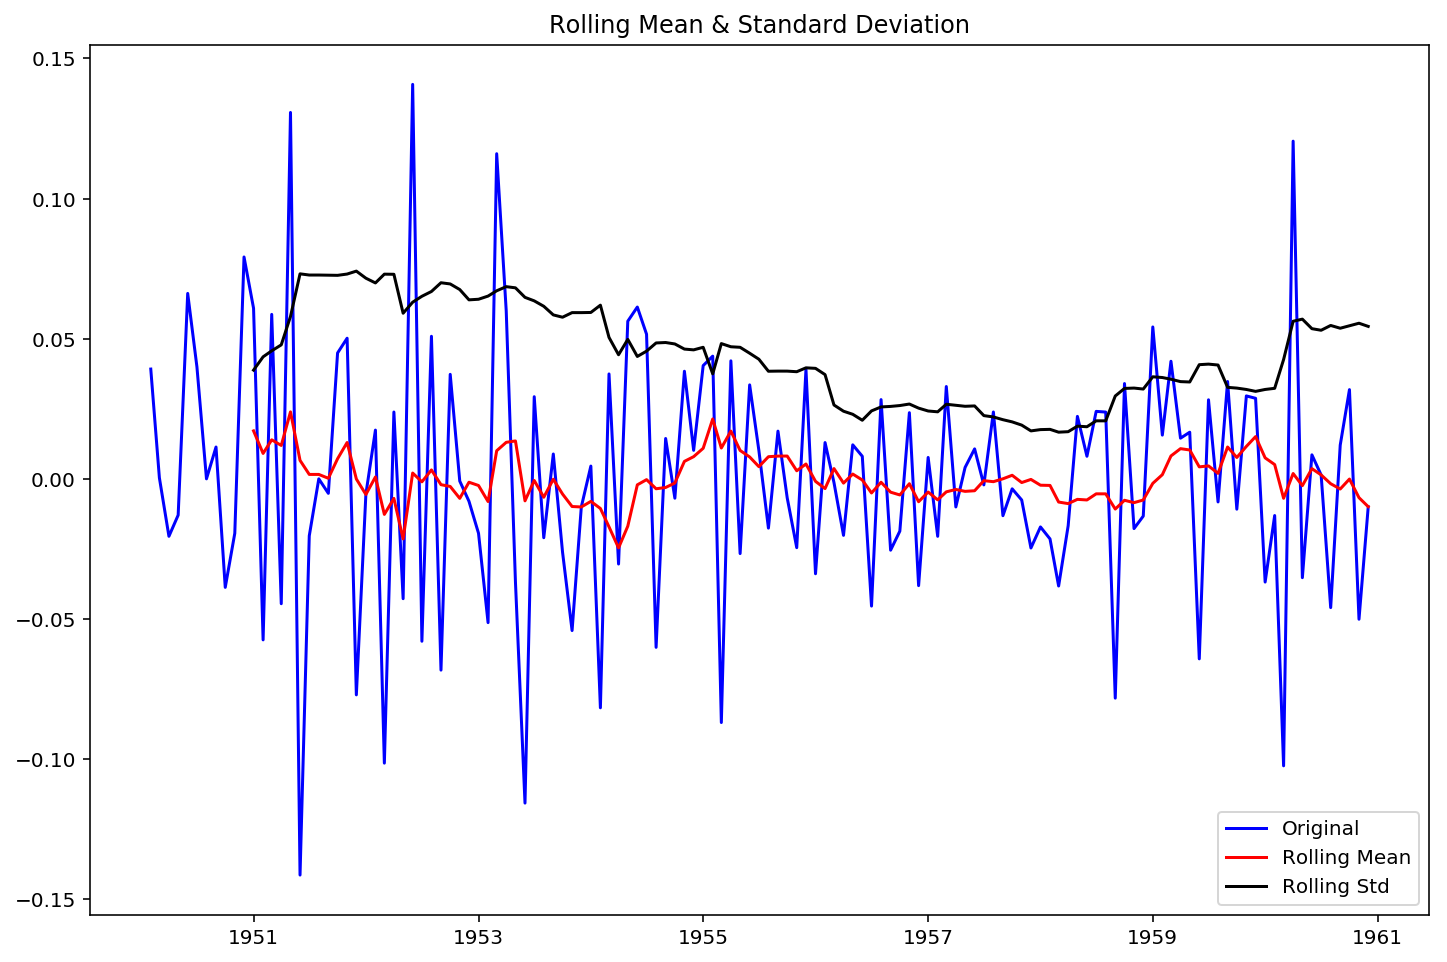

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [27]:
STATIONARIZE_USING = apply_differencing(series, 'Passengers', 'log_seasonal_first_difference' )
test_stationarity(series[STATIONARIZE_USING].dropna(inplace=False))

**Result:** We can now observe that the result of the ADF test is negative, and is outside the critical value boundary, which would suggest we can reject the NULL hypothesis and assume that the data is stationary. 


Great, we acheive a negative ADF score, looks like we can proceed with now thinking about looking at AutoCorrelation 

## AutoCorrelation Function (ACF)

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

##### ACF & PACF (Trend and mean reversion) 
 > Since *autocorrelation* is the linear correlation of a signal with itself at two different points in time, ACF (**autocorrelation function**) is just such correlation as a function of the lag ***h*** between two points of time, like 

 > PACF (**partial autocorrelation function**) is essentially the autocorrelation of a signal with itself at different points in time, with linear dependency with that signal at shorter lags removed, as a function of lag between points of time. Informally, the partial correlation between $x_t$ and $x_{t+h}$ is the autocorrelation between $x_t$ and $x_{t+h}$ without the contribution of 
$x_{t+1},x_{t+2},....,x_{t+h−1}$

**Autoregression Intuition**
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

**Moving Average Intuition**
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

### Autocorrelation and Partial Autocorrelation Plot

Original ACF/PACF Plots vs. Differenced ACF/PACF Plots



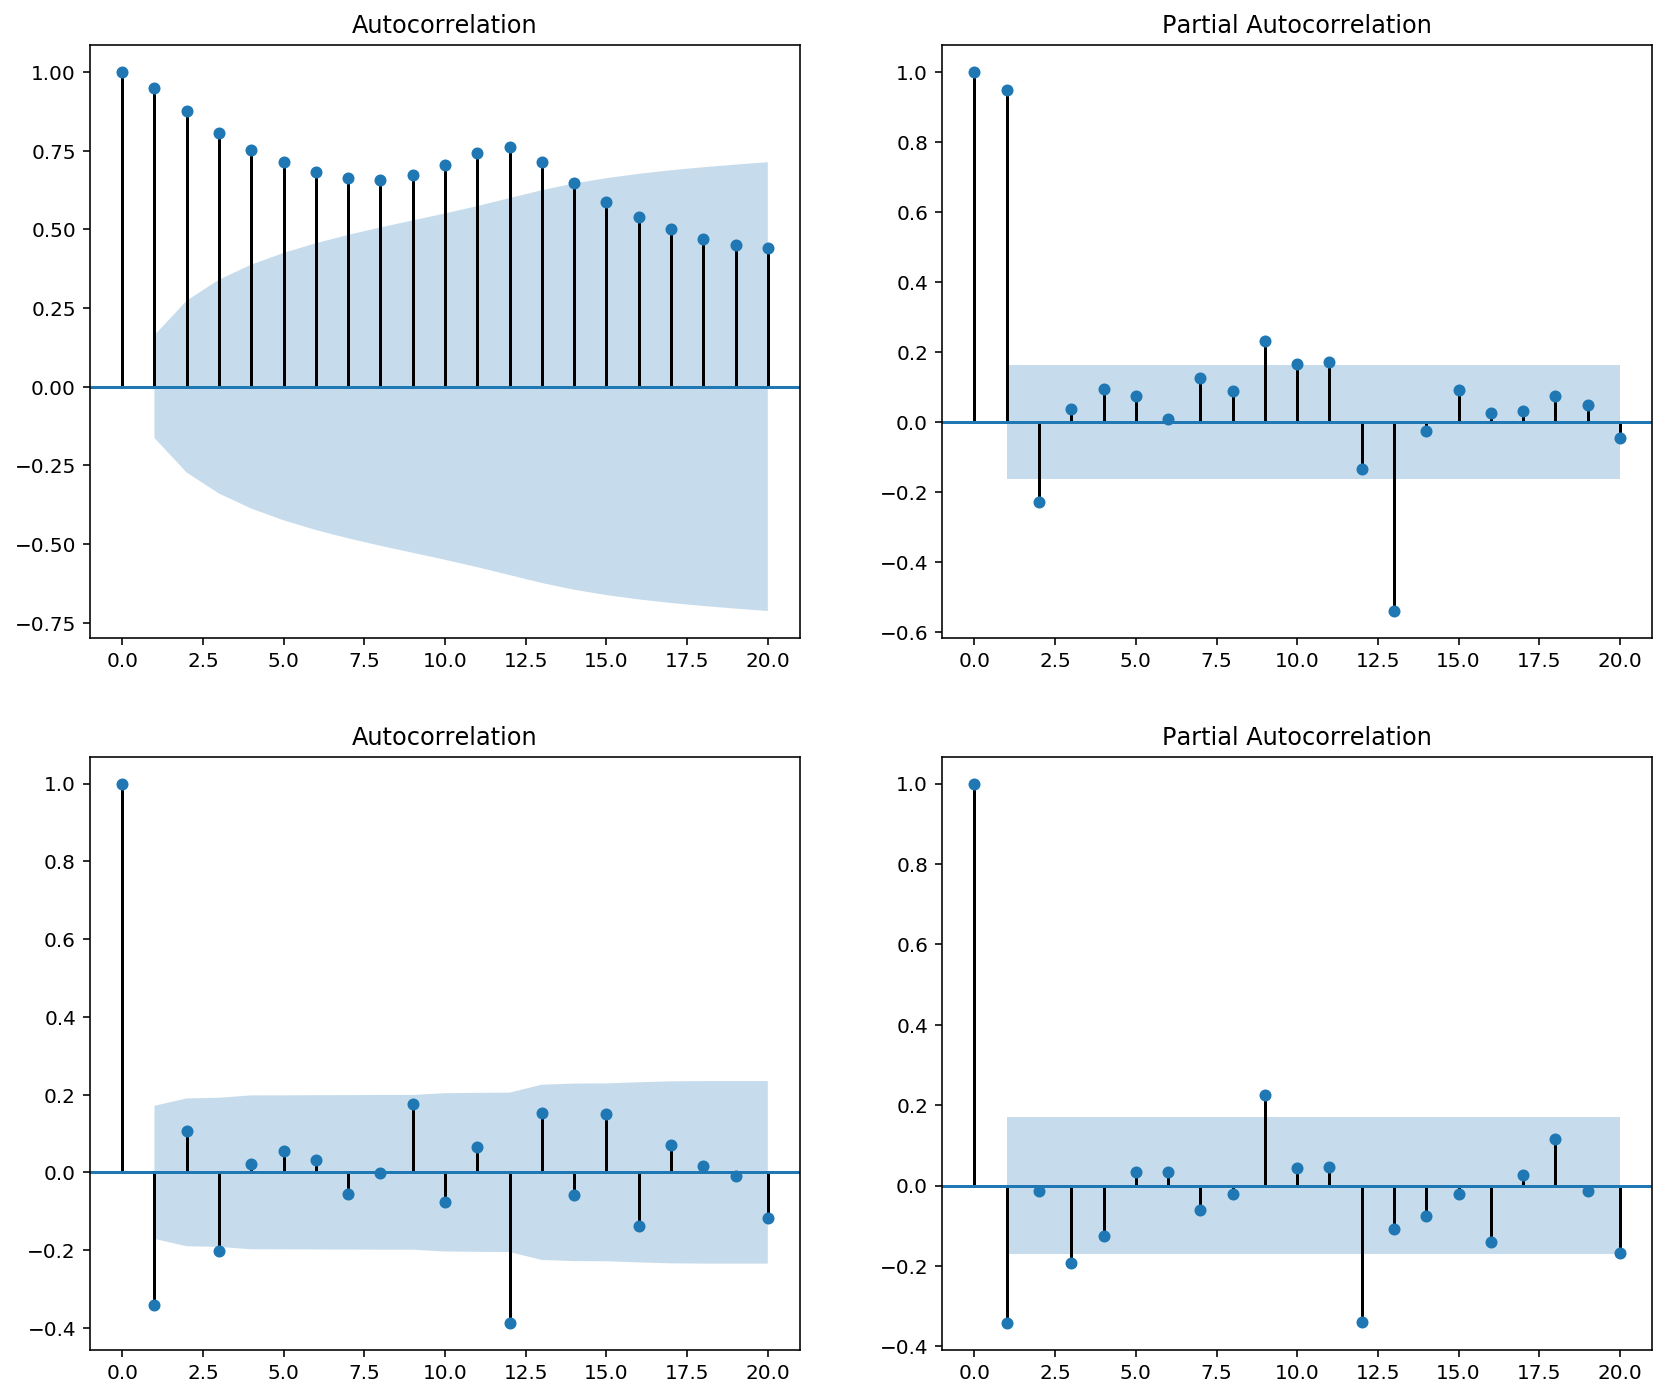

In [14]:
fig = plt.figure(figsize=(14,12))

print('Original ACF/PACF Plots vs. Differenced ACF/PACF Plots')

ax0_0 = fig.add_subplot(221)
#AutoCorrelation Plot
fig = sm.graphics.tsa.plot_acf(series.Passengers, lags=20, ax=ax0_0)

ax0_1 = fig.add_subplot(222)
#Partial Autocorrelation Plot
fig = sm.graphics.tsa.plot_pacf(series.Passengers, lags=20, ax=ax0_1)

print('')

ax1 = fig.add_subplot(223)
#AutoCorrelation Plot
fig = sm.graphics.tsa.plot_acf(series[STATIONARIZE_USING].iloc[13:], lags=20, ax=ax1)

ax2 = fig.add_subplot(224)
#Partial Autocorrelation Plot
fig = sm.graphics.tsa.plot_pacf(series[STATIONARIZE_USING].iloc[13:], lags=20, ax=ax2)
plt.show()


**Result**: The top two graphs, which are before differencing has been applied, and thus the data is still non-stationary,  demonstrates correlation is present.

When applying differencing, we can see the ACF and PACF plots demonstrate little correlation

These plots can be used to determine the optimal values for the p, d & q

http://people.duke.edu/~rnau/arimrule.htm

Some examples include:

Identifying the order of differencing:

 - d=0 if the series has no visible trend or ACF at all lags is low.
 - d≥1 if the series has visible trend or positive ACF values out to a high number of lags.

Identifying the number of AR and MA terms:

- p is equal to the first lag where the PACF value is above the significance level.
- q is equal to the first lag where the ACF value is above the significance level.

Identifying the seasonal part of the model:

- S is equal to the ACF lag with the highest value (typically at a high lag).
- D=1 if the series has a stable seasonal pattern over time.
- D=0 if the series has an unstable seasonal pattern over time.

Rule of thumb: d+D≤2

- P≥1 if the ACF is positive at lag S, else P=0.
- Q≥1 if the ACF is negative at lag S, else Q=0.

Rule of thumb: P+Q≤2


***

<a id='part_3'></a>
# Part 3. Forecast Modelling  - SARIMAX

An autoregressive integrated moving average with seasonality (SARIMAX) model is an generalization of an autoregressive moving average (ARMA) model. 

> *seasonal_order:* The (p,d,q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity
    - p and q  indicating the AR and MA orders (so that all lags up to those orders are included)
    - d an integer indicating the integration order of the process
    - s is an integer giving the periodicity (periods in season) e.g. 4 for quarterly data 
    


## Prepare training & test datasets

In [3]:
# ensure no NANs
series = series[~np.isnan(series.Passengers)]

# Option to eitehr select the differenced series or the original series
# Option 1
#y = series[STATIONARIZE_USING]

# Option 2
y = series.Passengers

# split into training and test sets
y_train = y[:'1958']
y_test = y['1959':]

print('Training set shape\n', y_train.shape, '\nTest set shape \n', y_test.shape)

Training set shape
 (120,) 
Test set shape 
 (24,)


## Parameter grid search 

We use the following method to search for the most appropriate p, d, q parameters

In [4]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]




best_aic =  float('inf')
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
#                                                 trend='n',
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))



/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals",

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood

Best SARIMAX(1, 1, 0)x(1, 2, 1, 12)12 model - AIC:727.3256892794774


## The Akaike Information Criterion

The Akaike information criterion (AIC) is a measure of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. 

It measures the trade-off between the goodness of fit of the model and the complexity of the model (number of included and estimated aprameters). The AIC is calculated as follows

<h1>$$AIC = 2k - 2ln(L)$$</h1>

where,
- **k** corresponds to the number of estimated parameters in the model
- **L** refers to the maximum value of the likelihood function for the model. 

It is important to note that the AIC only measures the in-sample model fit of the data given for training.



## Best model fit
The grid search found that the best model is a seasonal ARIMA model for y_test. The SARIMAX model will be trained on the training data y_train under the optimal parameter setting obtained from the grid search. If the seasonal order is not given, the standard ARIMA model will be applied to the input data.


In [5]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 1, 0),
                                seasonal_order=(1,2,1,12),#(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()


In [6]:
# print statistics
print(res.aic)
print(res.summary())


727.3256892794774
                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 2, 1, 12)   Log Likelihood                -359.663
Date:                            Thu, 01 Nov 2018   AIC                            727.326
Time:                                    04:03:12   BIC                            738.476
Sample:                                01-01-1949   HQIC                           731.854
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3570      0.091     -3.909      0.000      -0.536      -0.178
ar.S.L12      -0.

**Notes**:
    
- The Jarque-Bera Test,a type of Lagrange multiplier test, is a test for normality. The null hypothesis for the test is that the data is normally distributed; the alternate hypothesis is that the data does not come from a normal distribution. In general, a large J-B value indicates that errors are not normally distributed.





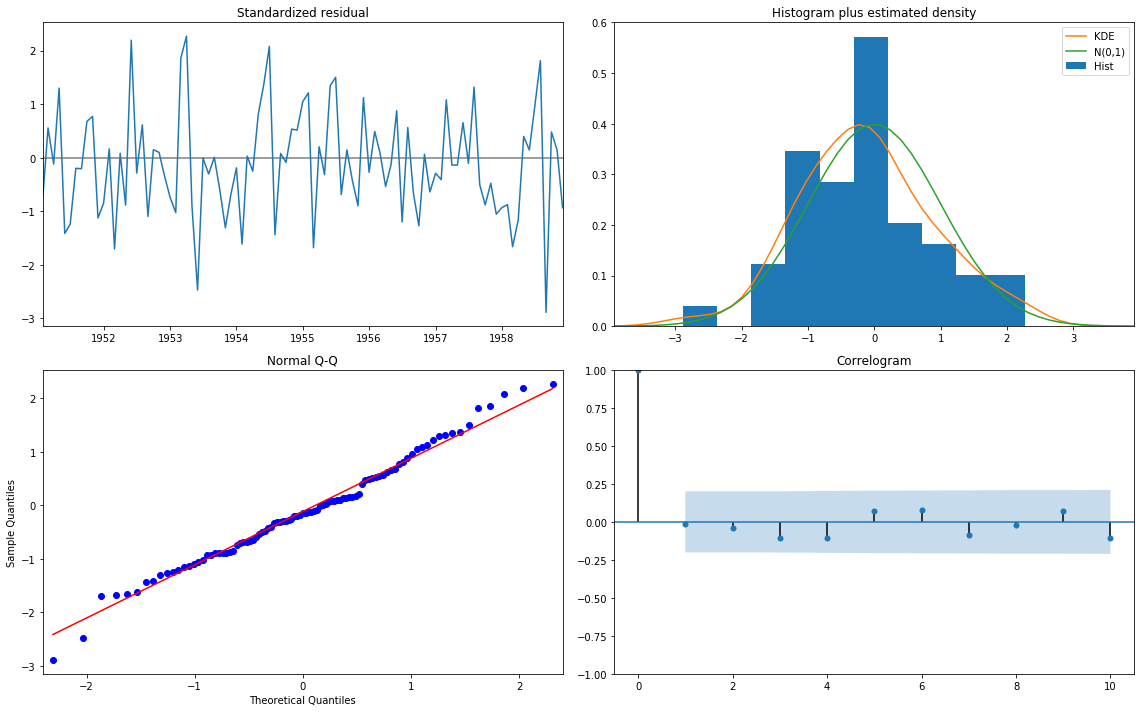

In [7]:
# the diagnostiv of the results
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

## One step ahead prediction

The get_prediction and conf_int methods calculate predictions for future points in time for the previously fitted model and the confidence intervals associated with a prediction, respectively. The dynamic=False argument causes the method to produce a one-step ahead prediction of the time series

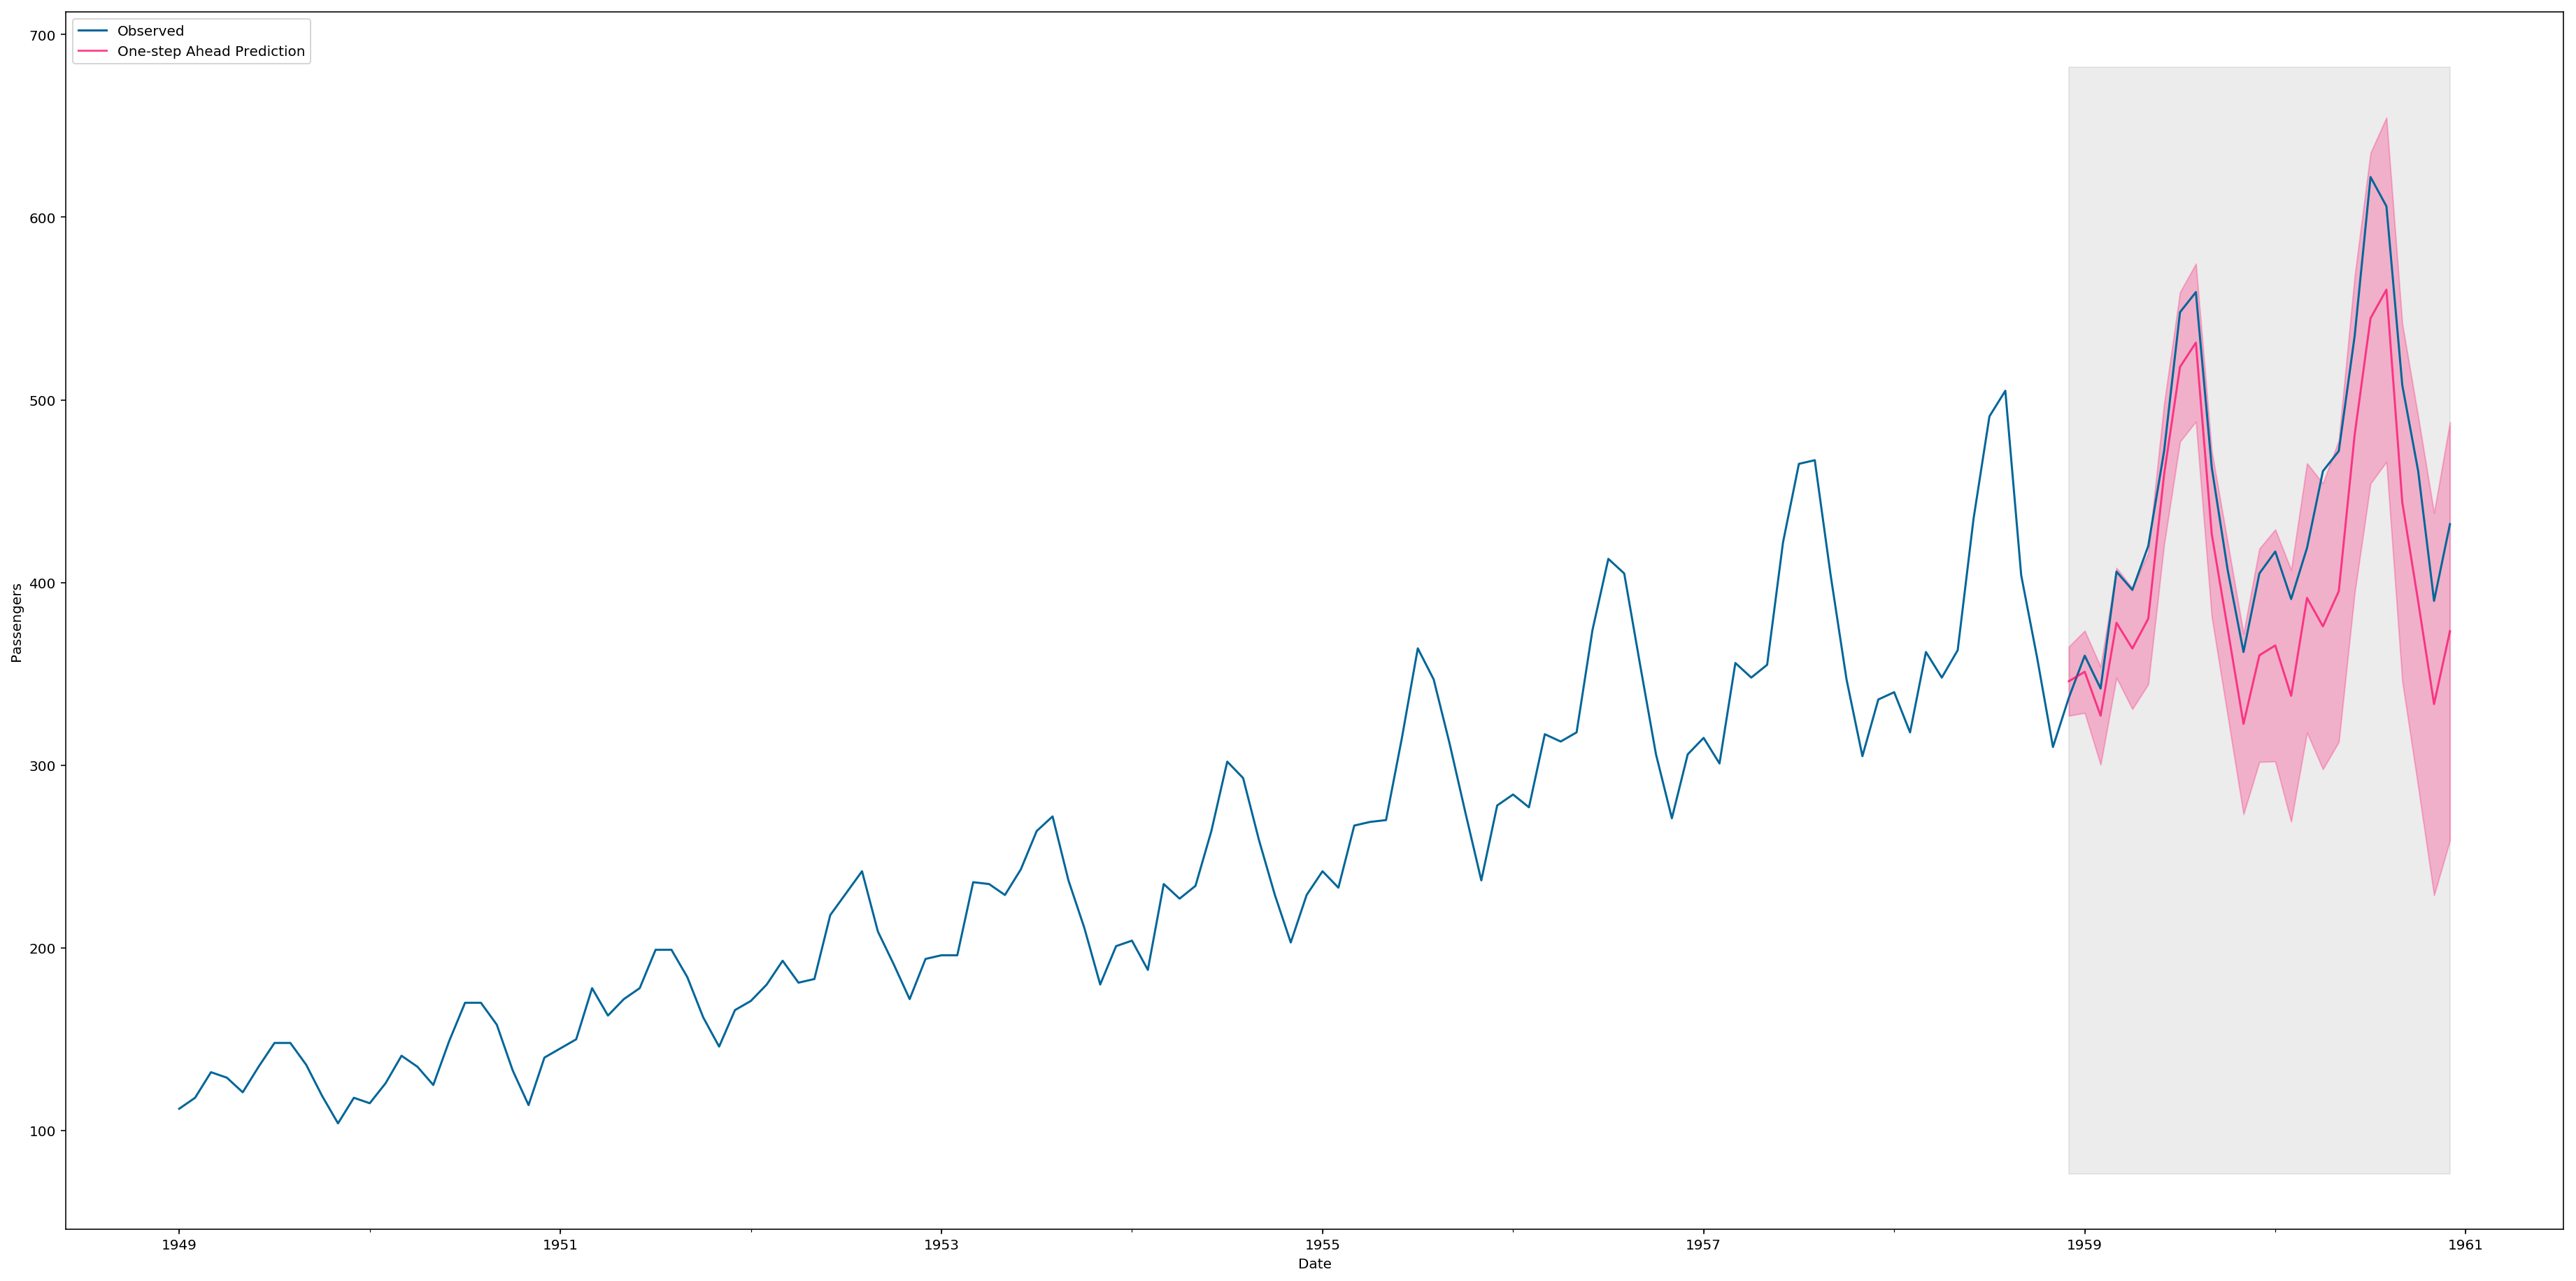

In [14]:
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('1958-12-01'), 
                          end=pd.to_datetime('1960-12-01'),
                          dynamic=True)
pred_ci = pred.conf_int()
 
# plot in-sample-prediction
ax = y['1949':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc='upper left')
plt.show()

## One-step Ahead Accuracy

To quantify the accuracy between model fit and true observations wie will use the mean squared error (MSE). The MSE computes the squared difference between the true and predicted value. 
    
    

In [9]:
import math
y_hat = pred.predicted_mean
y_true = y['1958-12-01':]
 
# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 2305.05 MSE (48.01 RMSE)


## Out of Sample Prediction

To put the model to the real test with a 24-month-head prediction. This requires to pass the argument dynamic=False when using the get_prediction method.

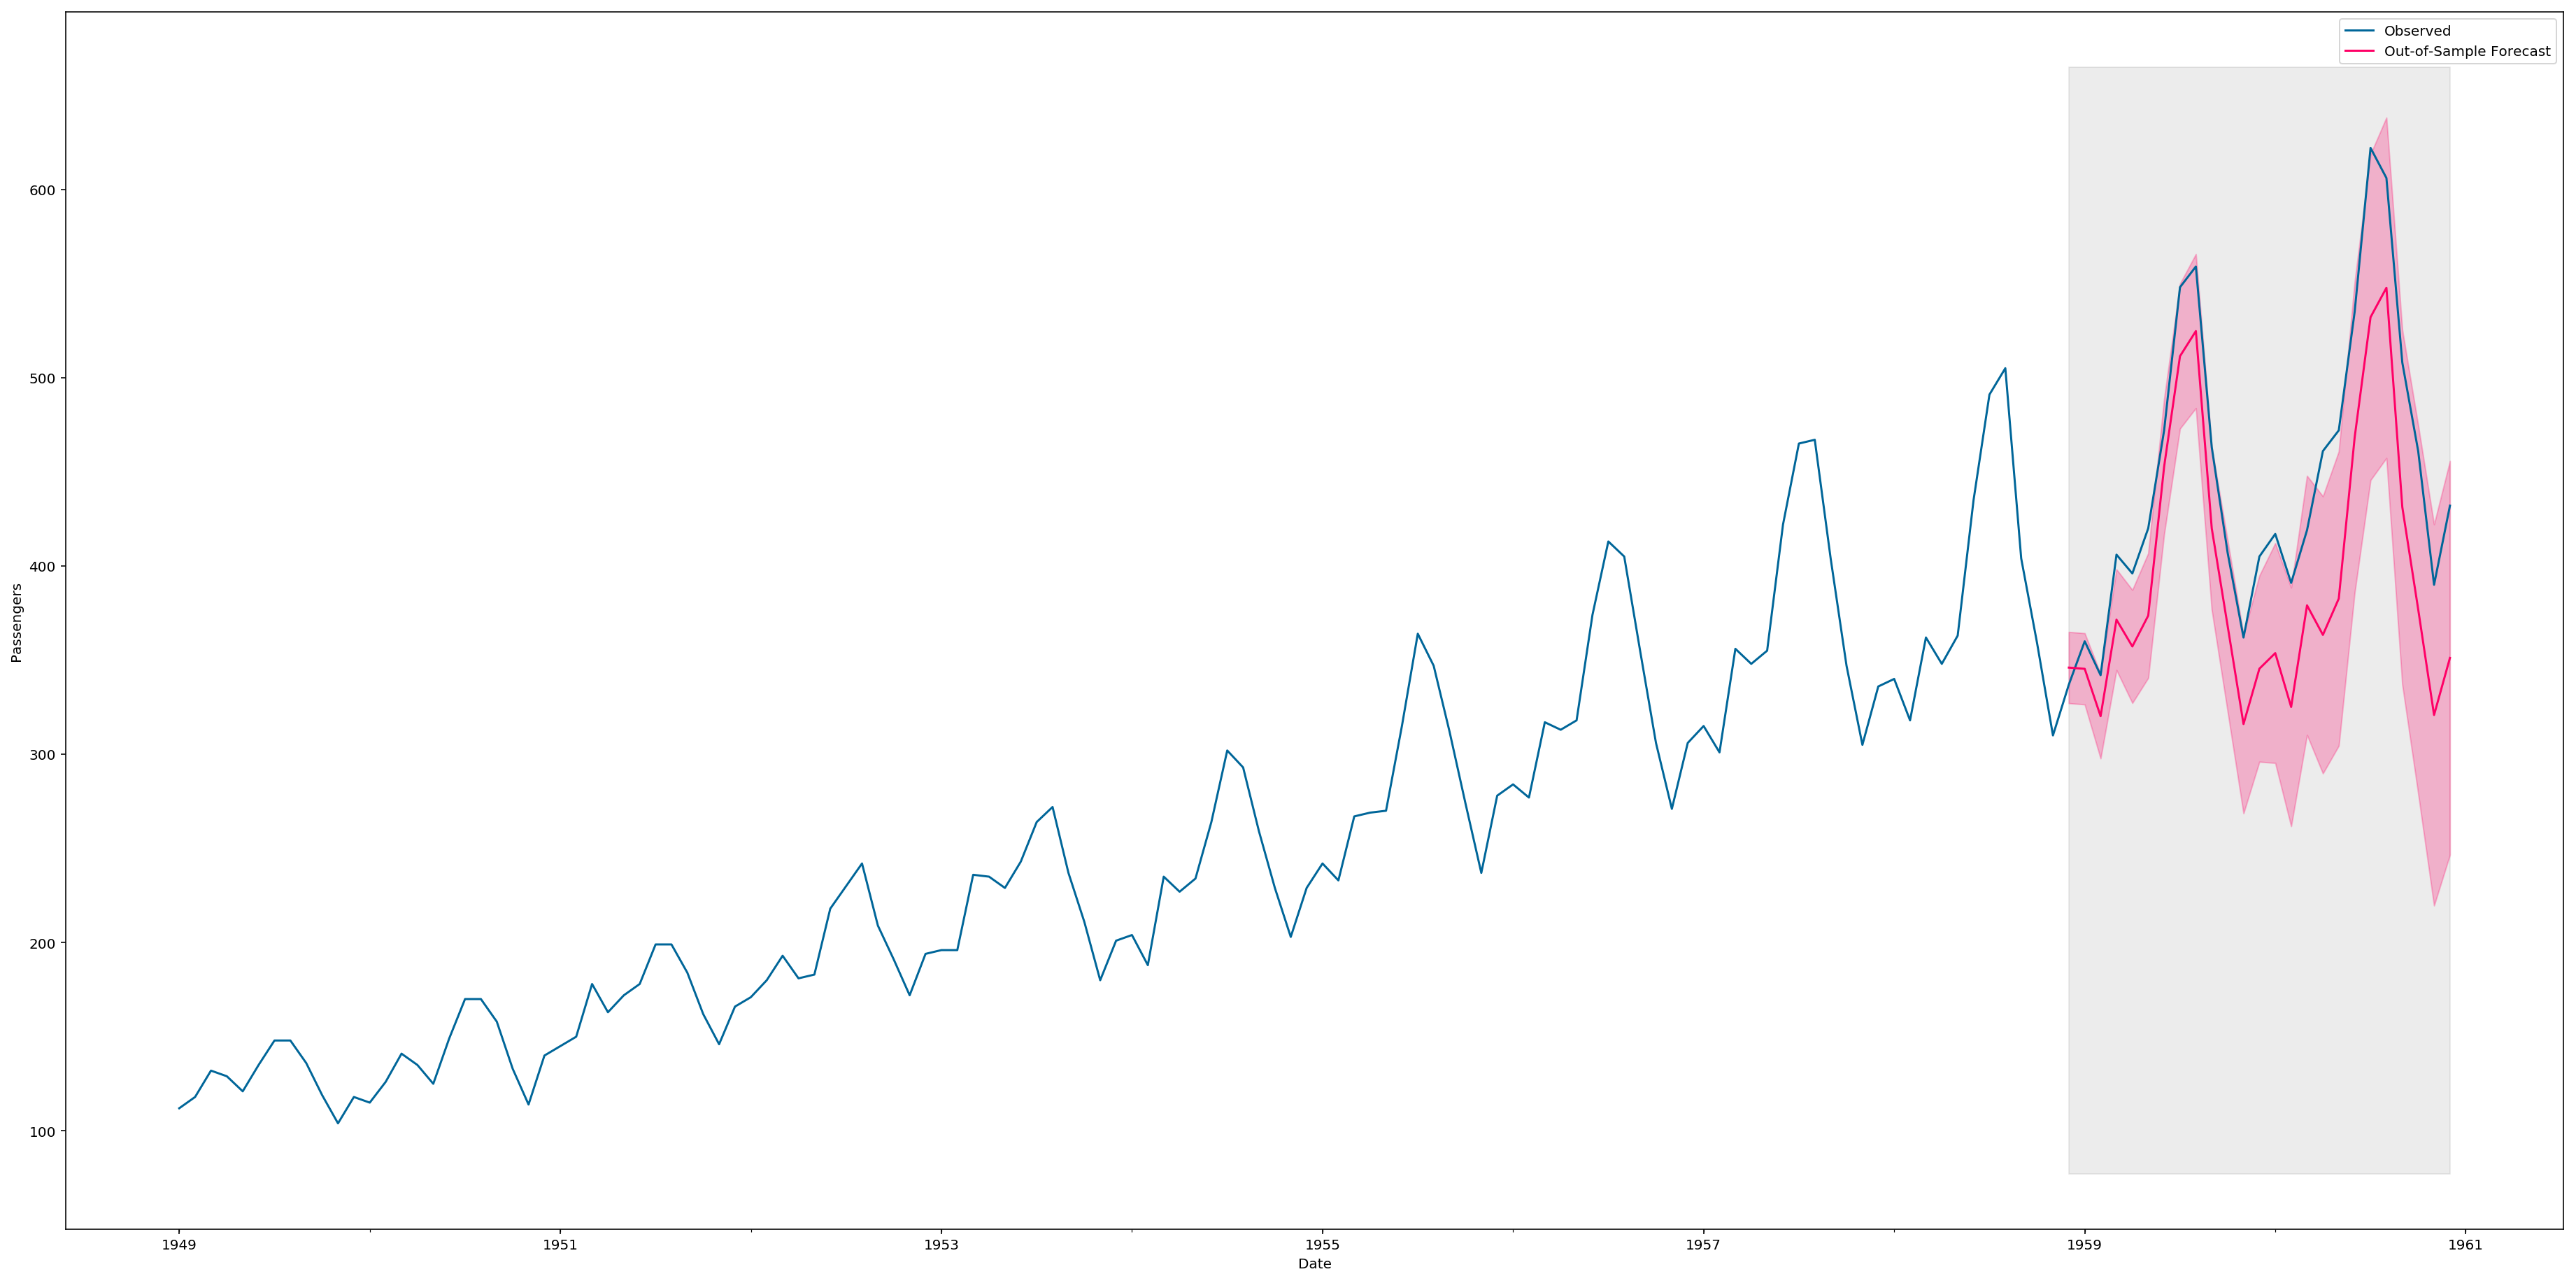

In [15]:
# predict out of sample and find confidence bounds
pred_out = res.get_prediction(start=pd.to_datetime('1958-12-01'), 
                              end=pd.to_datetime('1960-12-01'), 
                              dynamic=False, full_results=True)
pred_out_ci = pred_out.conf_int()
 
# plot time series and out of sample prediction
ax = y['1949':].plot(label='Observed', color='#006699')
pred_out.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast', color='#ff0066')
ax.fill_between(pred_out_ci.index,
                pred_out_ci.iloc[:, 0],
                pred_out_ci.iloc[:, 1], color='#ff0066', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

## Overall Performance


In [11]:
# extract the predicted and true values of our time series
y_hat = pred_out.predicted_mean
y_true = y['1958-12-01':]
 
# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 3406.72 MSE (58.37 RMSE)


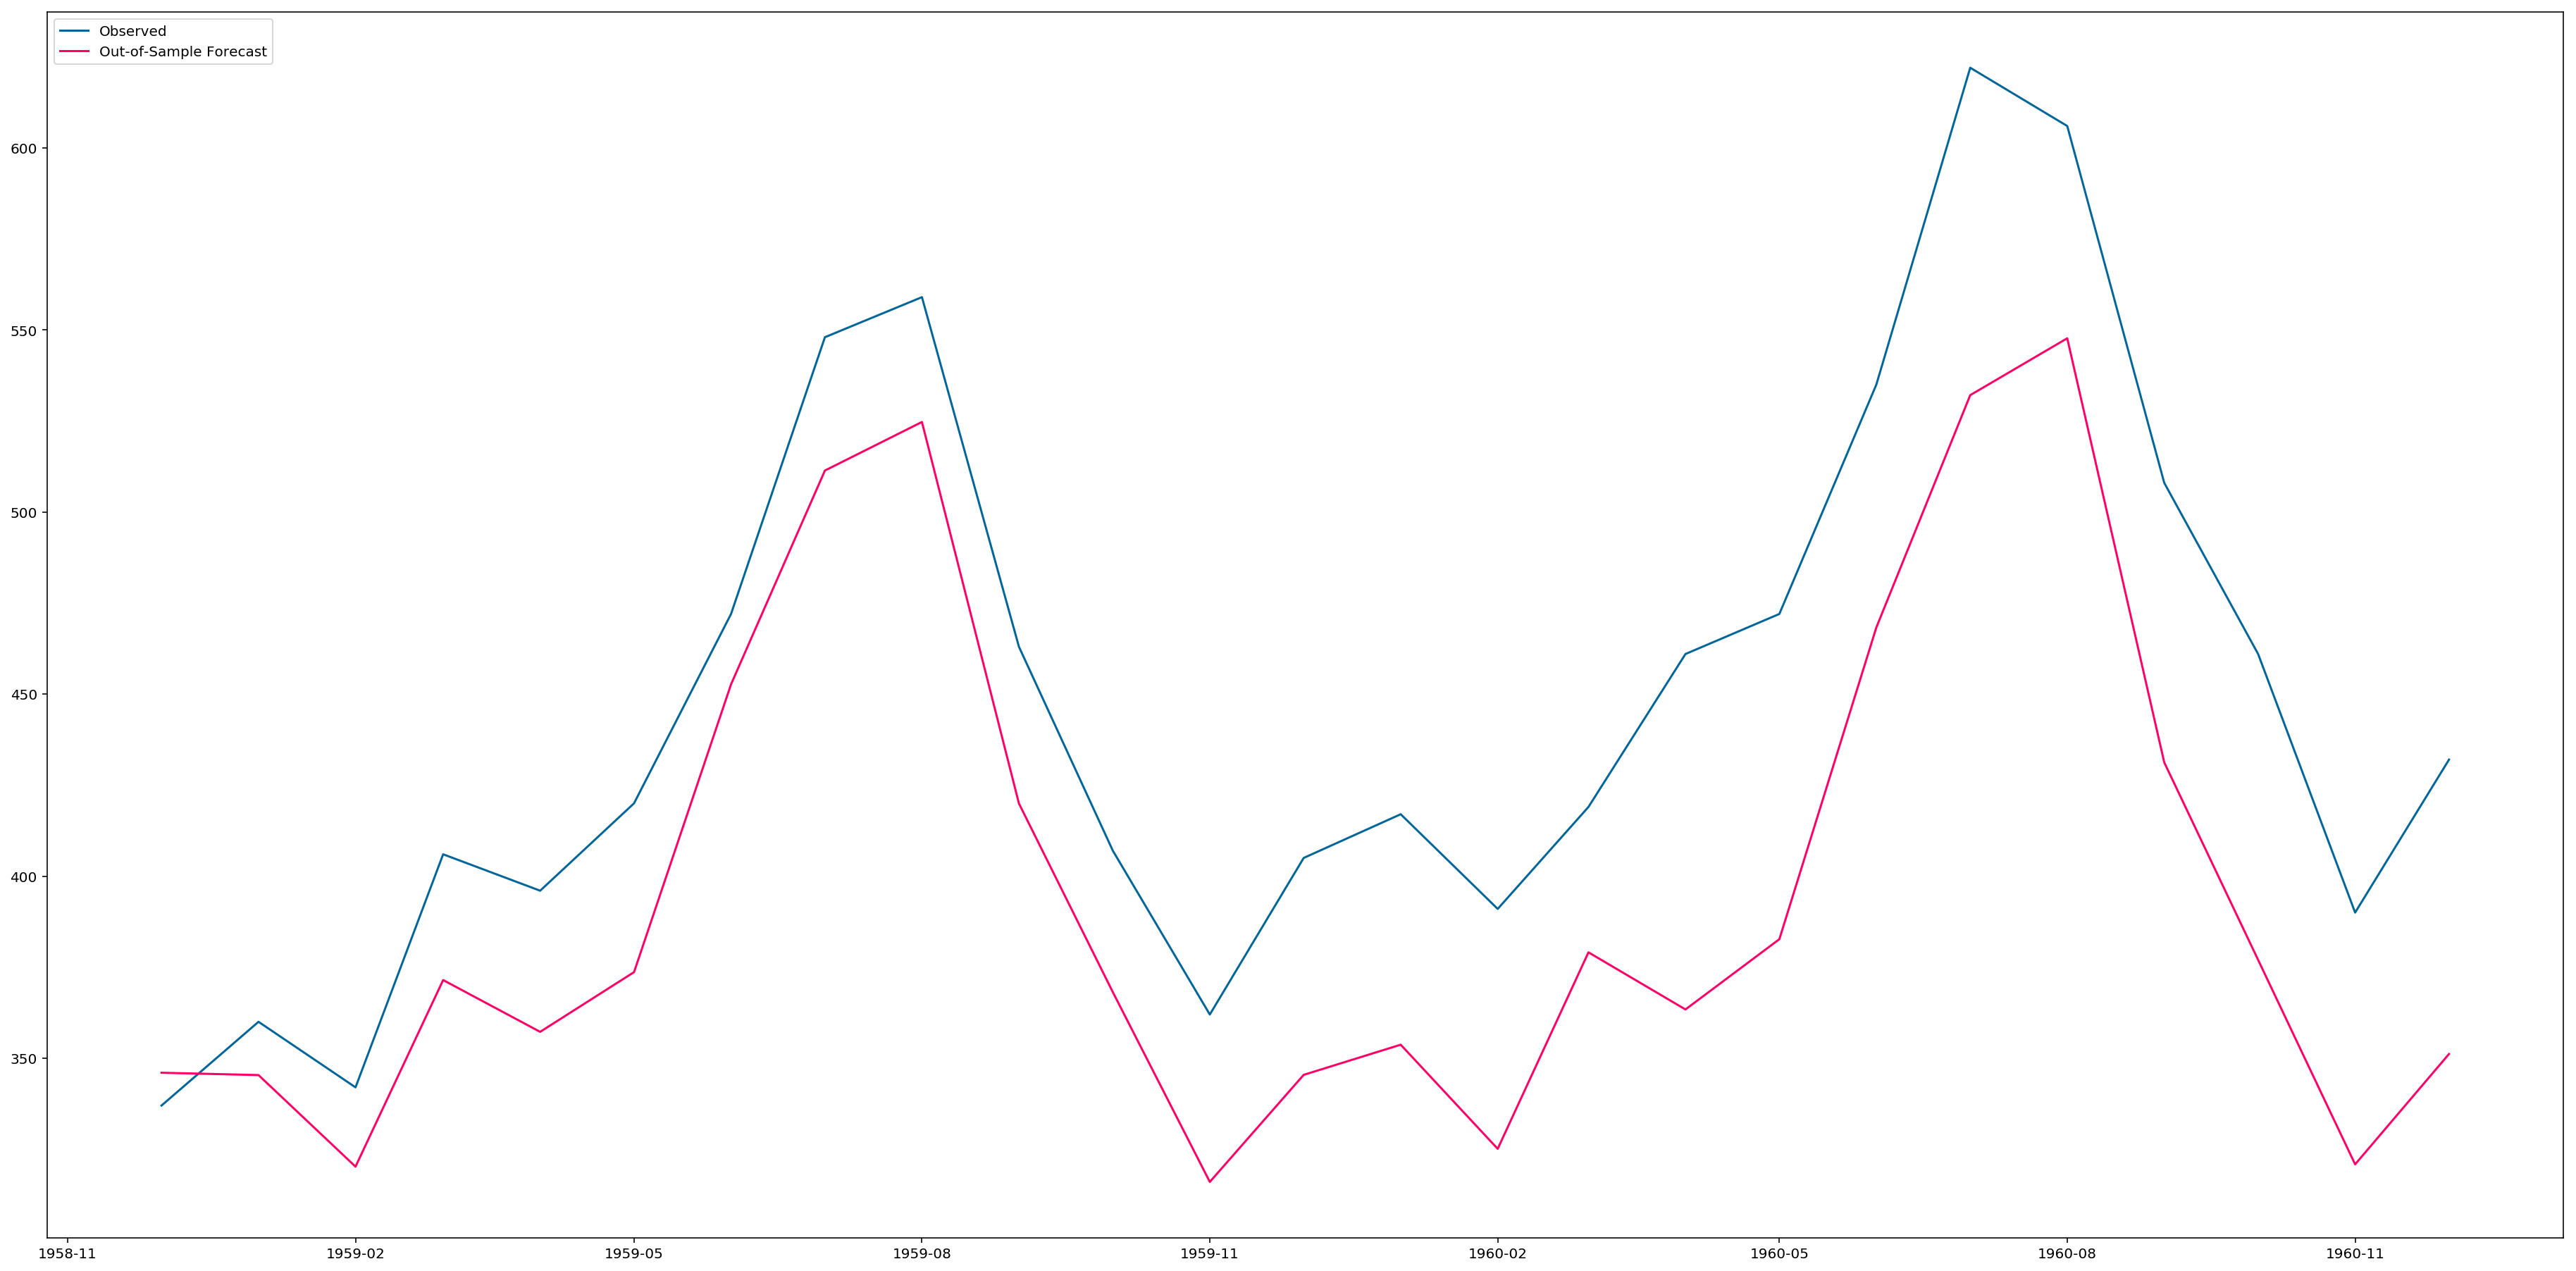

In [16]:
plt.plot(y_true, label='Observed', color='#006699')
plt.plot(y_hat, label='Out-of-Sample Forecast', color='#ff0066')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc='upper left');
plt.show()

## Long-term forcasting

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


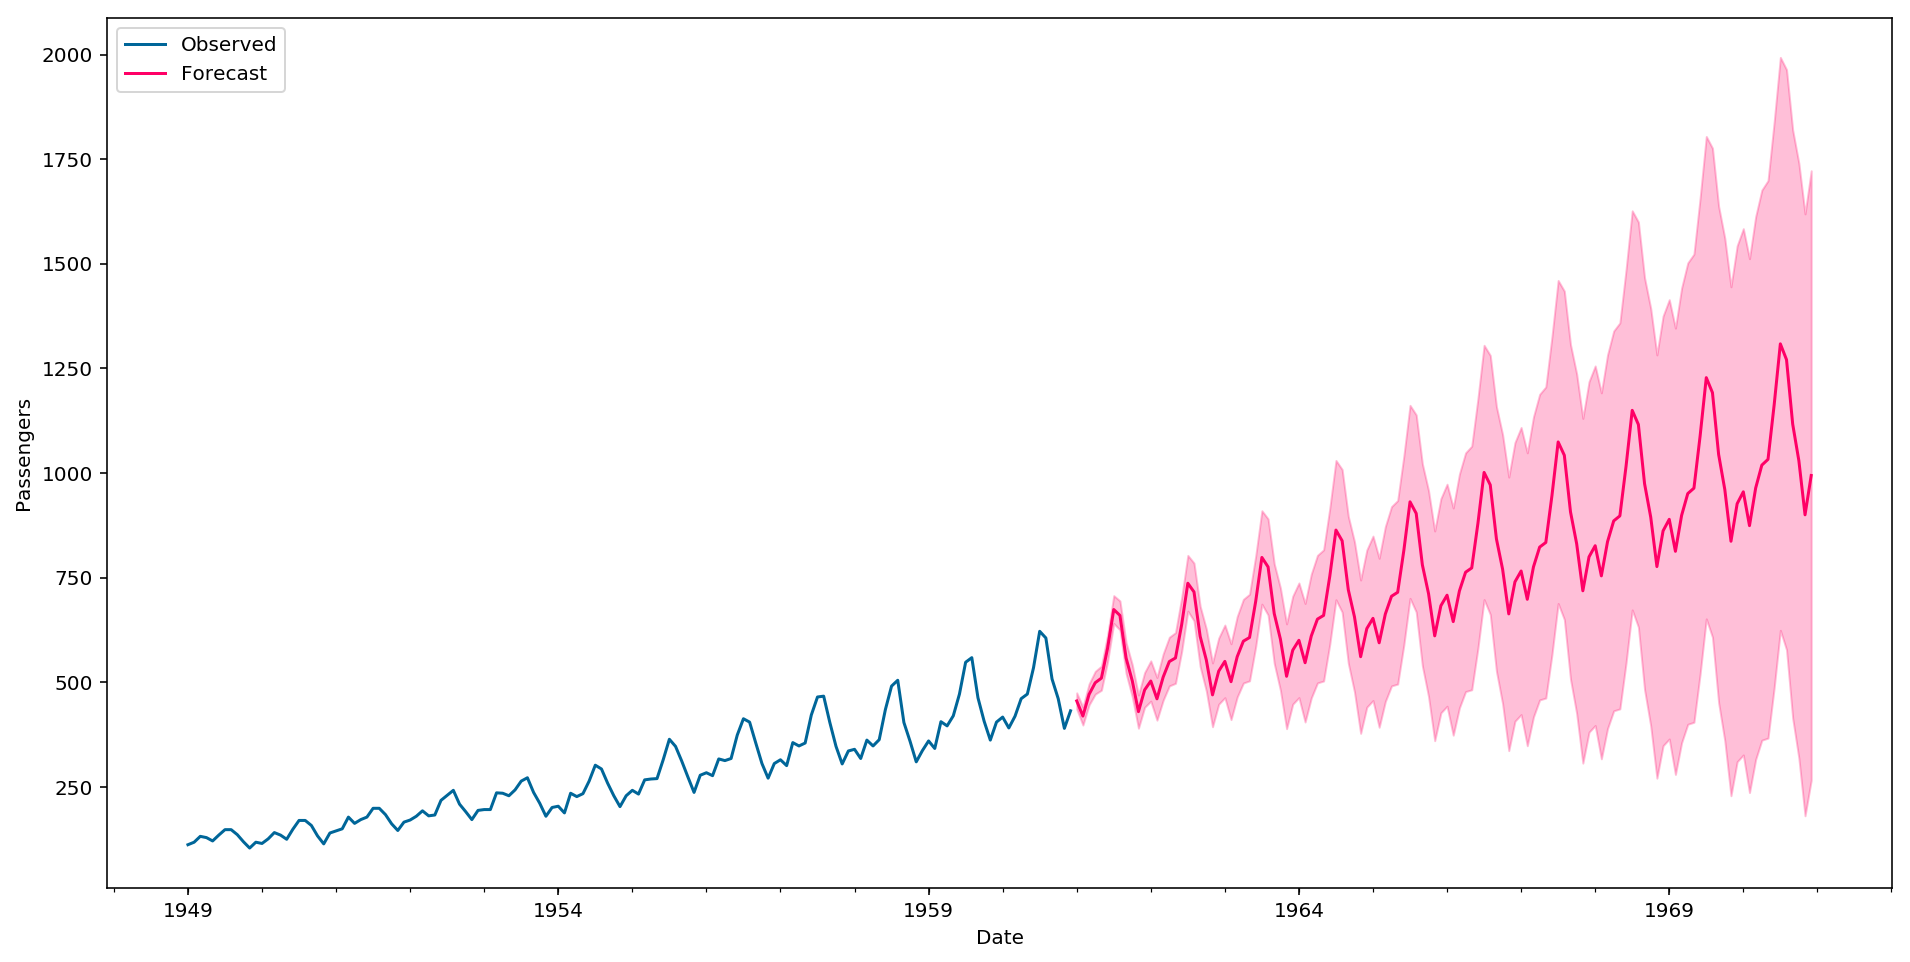

In [17]:
# build model and fit
res = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 1, 3),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 
# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=120)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');
plt.legend(loc='upper left')
plt.show()

**Result:** As the forecast window increases (e.g. as we try and forecast further into the future) we observe the confidence intervals become bigger, as the error increases, this we are less likely to 'trust' the predictions

<a id='part_one'></a>

# Part 4: Deep Learning (LSTM) Approach

In time series forecasting, where classical linear methods are used it can be difficult to adapt to multivariate or multiple input forecasting problems.Neural networks on the otherhand, like Long Short-Term Memory (LSTM) recurrent neural networks can  seamlessly model problems with multiple input variables.

<img src="https://i.stack.imgur.com/TuHv1.png" width="30%" height="30%" />

 > **Long Short-term memory (LSTM)** is a neural network architecture that includes feedback loops between
elements. This can also simulate memory, by passing the previous signals through the same nodes. LSTM neural networks
are suitable for time series analysis because they can more effectively recognize patterns and regimes across different time
scales.

<table ><tr>
    <td><img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png" height="50%" width="50%" /></td>
    <td><h1>&nbsp;>&nbsp;</h1></td>
    <td><img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" height="50%" width="50%"/></td>
    </tr></table>

In [43]:
import keras
print('Keras Version {}'.format(keras.__version__))
import tensorflow as tf
print('Tensorflow Version {}'.format(tf.__version__))
import cntk
print('CNTK Version {}'.format(cntk.__version__))

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Keras Version 2.2.2
Tensorflow Version 1.1.0
CNTK Version 2.5.1


In [46]:
from keras import backend as K
import os
from importlib import reload

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("cntk")

In [47]:
from pandas import concat

#credit to machine learning mastery
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (i))]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

series
lstm_dataset = series.Passengers
# ensure all data is float
lstm_dataset = lstm_dataset.astype('float32')

#frame as supervised dataset (single lag)
reframed = series_to_supervised(lstm_dataset, 10, 1)
column_names = reframed.columns

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)


# frame as supervised learning
reframed = pd.DataFrame(reframed, columns=column_names)
#reframed = pd.DataFrame(reframed)
print(reframed.head())

   var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
0    0.017582   0.030769   0.061538   0.054945   0.037363   0.059846   
1    0.030769   0.061538   0.054945   0.037363   0.068132   0.084942   
2    0.061538   0.054945   0.037363   0.068132   0.096703   0.084942   
3    0.054945   0.037363   0.068132   0.096703   0.096703   0.061776   
4    0.037363   0.068132   0.096703   0.096703   0.070330   0.028958   

   var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)  
0   0.084942   0.084942   0.061776   0.028958  0.000000  
1   0.084942   0.061776   0.028958   0.000000  0.027027  
2   0.061776   0.028958   0.000000   0.027027  0.021236  
3   0.028958   0.000000   0.027027   0.021236  0.042471  
4   0.000000   0.027027   0.021236   0.042471  0.071429  


In [49]:
# split into train and test sets
values = reframed.values
train = values[:100, :]
test = values[100:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(100, 1, 10) (100,) (34, 1, 10) (34,)


In [50]:
#wrap all the code up to create a dataset

def create_supervised_ml_datasets_from_dataframe(input_dataframe, n_lags):
    
    lstm_dataset = input_dataframe
    # ensure all data is float
    lstm_dataset = lstm_dataset.astype('float32')

    #frame as supervised dataset (single lag)
    reframed = series_to_supervised(lstm_dataset, n_lags, 1)
    column_names = reframed.columns

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    reframed = scaler.fit_transform(reframed)


    # frame as supervised learning
    reframed = pd.DataFrame(reframed, columns=column_names)
    
    values = reframed.values
    train = values[:100, :]
    test = values[100:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    return train_X, train_y, test_X, test_y, scaler

In [51]:
train_X, train_y, test_X, test_y, scaler = create_supervised_ml_datasets_from_dataframe(series.Passengers, 14)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(100, 1, 14) (100,) (30, 1, 14) (30,)


In [52]:
# design network
lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_model.add(Dense(1, activation='linear'))
lstm_model.compile(loss='mae', optimizer='adam')
lstm_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               46000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________


**Note on Activation Functions:**

- What is Activation Function: It’s just a node that you add to the output end of any neural network. It is also known as Transfer Function. It can also be attached in between two Neural Networks.

- Why we use Activation functions with Neural Networks? - It is used to determine the output of neural network like yes or no. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function). 

Experimentation is important here, as the activation function (and the size of the LSTM cells) plays an important role in determining how well the model fits and performs

In [53]:
# fit network
history = lstm_model.fit(train_X, train_y, epochs=200, batch_size=36, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 100 samples, validate on 30 samples
Epoch 1/200
 36/100 [=========>....................] - ETA: 0s - loss: 0.1129

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input2170") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input2639") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


100/100 [==============================] - 0s 4ms/step - loss: 0.2426 - val_loss: 0.5155
Epoch 2/200
100/100 [==============================] - 0s 331us/step - loss: 0.1903 - val_loss: 0.4083
Epoch 3/200
100/100 [==============================] - 0s 227us/step - loss: 0.1387 - val_loss: 0.2994
Epoch 4/200
100/100 [==============================] - 0s 369us/step - loss: 0.0903 - val_loss: 0.1917
Epoch 5/200
100/100 [==============================] - 0s 290us/step - loss: 0.0568 - val_loss: 0.1182
Epoch 6/200
100/100 [==============================] - 0s 242us/step - loss: 0.0561 - val_loss: 0.1063
Epoch 7/200
100/100 [==============================] - 0s 221us/step - loss: 0.0669 - val_loss: 0.1152
Epoch 8/200
100/100 [==============================] - 0s 222us/step - loss: 0.0715 - val_loss: 0.1140
Epoch 9/200
100/100 [==============================] - 0s 229us/step - loss: 0.0679 - val_loss: 0.1050
Epoch 10/200
100/100 [==============================] - 0s 276us/step - loss: 0.0604 - 

100/100 [==============================] - 0s 261us/step - loss: 0.0159 - val_loss: 0.0414
Epoch 157/200
100/100 [==============================] - 0s 242us/step - loss: 0.0159 - val_loss: 0.0413
Epoch 158/200
100/100 [==============================] - 0s 220us/step - loss: 0.0159 - val_loss: 0.0406
Epoch 159/200
100/100 [==============================] - 0s 277us/step - loss: 0.0158 - val_loss: 0.0416
Epoch 160/200
100/100 [==============================] - 0s 222us/step - loss: 0.0159 - val_loss: 0.0419
Epoch 161/200
100/100 [==============================] - 0s 328us/step - loss: 0.0157 - val_loss: 0.0406
Epoch 162/200
100/100 [==============================] - ETA: 0s - loss: 0.011 - 0s 386us/step - loss: 0.0157 - val_loss: 0.0407
Epoch 163/200
100/100 [==============================] - 0s 330us/step - loss: 0.0157 - val_loss: 0.0410
Epoch 164/200
100/100 [==============================] - 0s 240us/step - loss: 0.0156 - val_loss: 0.0398
Epoch 165/200
100/100 [======================

## Let's check the Training and Validation Loss to see if there is convergence (and also identify Underfitting, Overfitting, or Good fit)

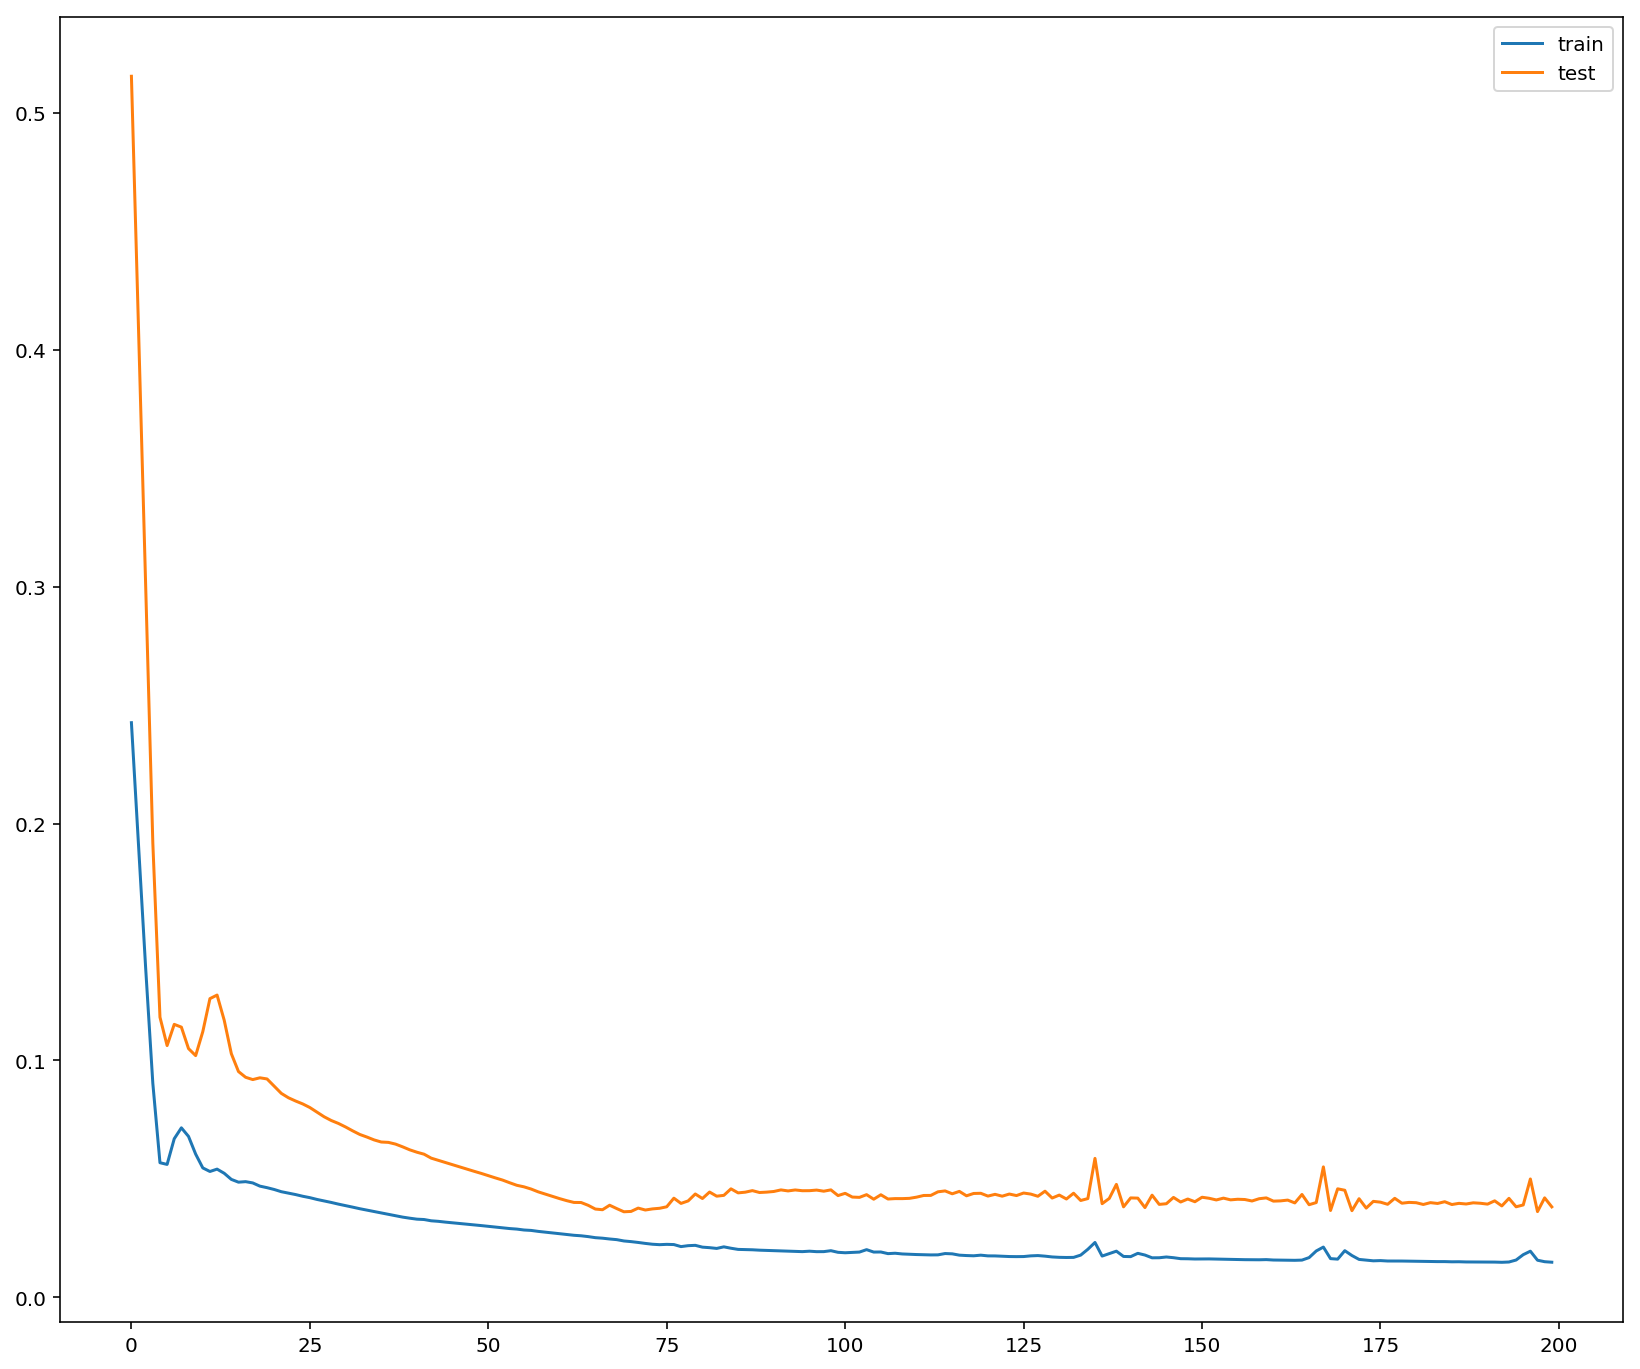

In [54]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

**Note:** We use Mean Absolute Error (MAE) to measure the error of the LSTM Neural Network. However, for the SARIMAX Model, we used RMSE

**Mean Absolute Error (MAE):** MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

**Root mean squared error (RMSE):** RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.

**MAE and MSE Comparison**
- Similarities: Both MAE and RMSE express average model prediction error in units of the variable of interest. Both metrics can range from 0 to ∞ and are indifferent to the direction of errors. They are negatively-oriented scores, which means lower values are better.

- Differences: Taking the square root of the average squared errors has some interesting implications for RMSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. The three tables below show examples where MAE is steady and RMSE increases as the variance associated with the frequency distribution of error magnitudes also increases.


In [37]:
from numpy import concatenate
from sklearn.metrics import mean_squared_error
print(train_X.shape)
print(test_X.shape)
print(test_y.shape)
# make a prediction
yhat = lstm_model.predict(test_X)

#to reverse MinMax reshape based on original shape
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
rmse_title_lstm = 'Test RMSE: %.3f' % rmse
print(rmse_title_lstm)

(100, 1, 14)
(30, 1, 14)
(30,)
Test RMSE: 22.550


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input4") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


## Experimentation with the lag parameter

In [153]:
maes = {}
rmses = {}
for lag_i in range(10,15):
    print('Training for {} Lags'.format(lag_i))
    train_X, train_y, test_X, test_y, scaler = create_supervised_ml_datasets_from_dataframe(series.Passengers, lag_i)
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    lstm_model.add(Dense(1, activation='linear'))
    lstm_model.compile(loss='mae', optimizer='adam')
    
    history = lstm_model.fit(train_X, train_y, epochs=200, batch_size=36, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    train_idx = 'train_'+str(lag_i)
    test_idx = 'test_'+str(lag_i)
    yhat = lstm_model.predict(test_X)

    #to reverse MinMax reshape based on original shape
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
   
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:,0:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#     rmse_title_lstm = 'Test RMSE: %.3f' % rmse
#     print(rmse_title_lstm)
    
    rmses[str(lag_i)] = rmse
    maes[train_idx] = history.history['loss']
    maes[test_idx] = history.history['val_loss']

#lowest rmse
min_rmse = np.inf
best_lag = 1
for k,v in rmses.items():
    if v < min_rmse:
        min_rmse = v
        best_lag = k

print('Best lag setting: {0}, RMSE: {1}'.format(best_lag, min_rmse))
# print(best_lag)

    

Training for 10 Lags


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input127189") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input127658") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Training for 11 Lags


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input129555") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input130024") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Training for 12 Lags


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input131921") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input132390") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Training for 13 Lags


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input134287") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input134756") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Training for 14 Lags


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input136653") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input137122") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Best lag setting: 14, RMSE: 16.685035129009773


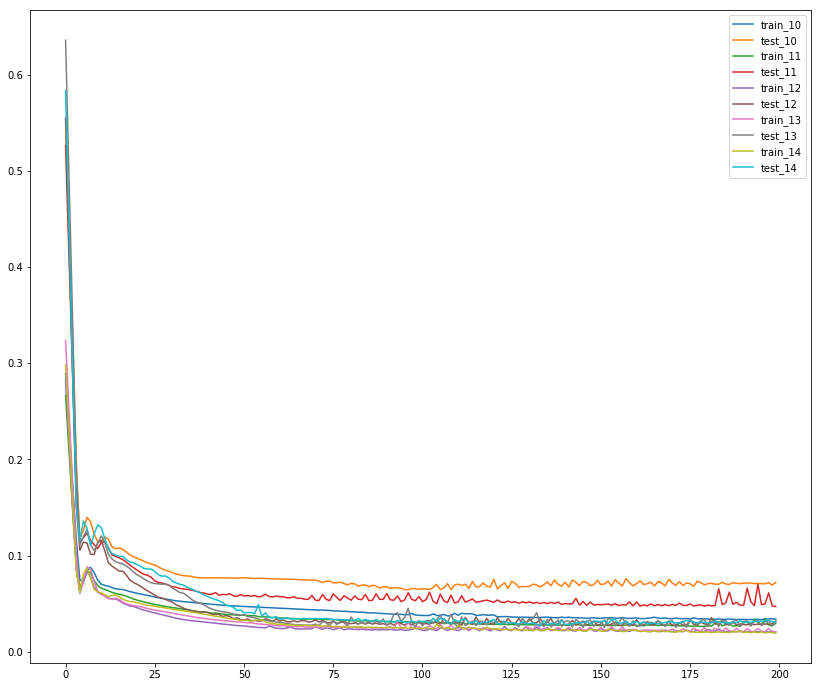

In [166]:
for k,v in maes.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()

In [167]:
print('Total Observations:',lstm_dataset.shape[0])
print('Total Predictions: ',len(inv_yhat))
# list(inv_yhat)

Total Observations: 144
Total Predictions:  30


## Finally create a new dataframe from the original series, and then take a look at it before we plot the predictions of the best fitting model

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


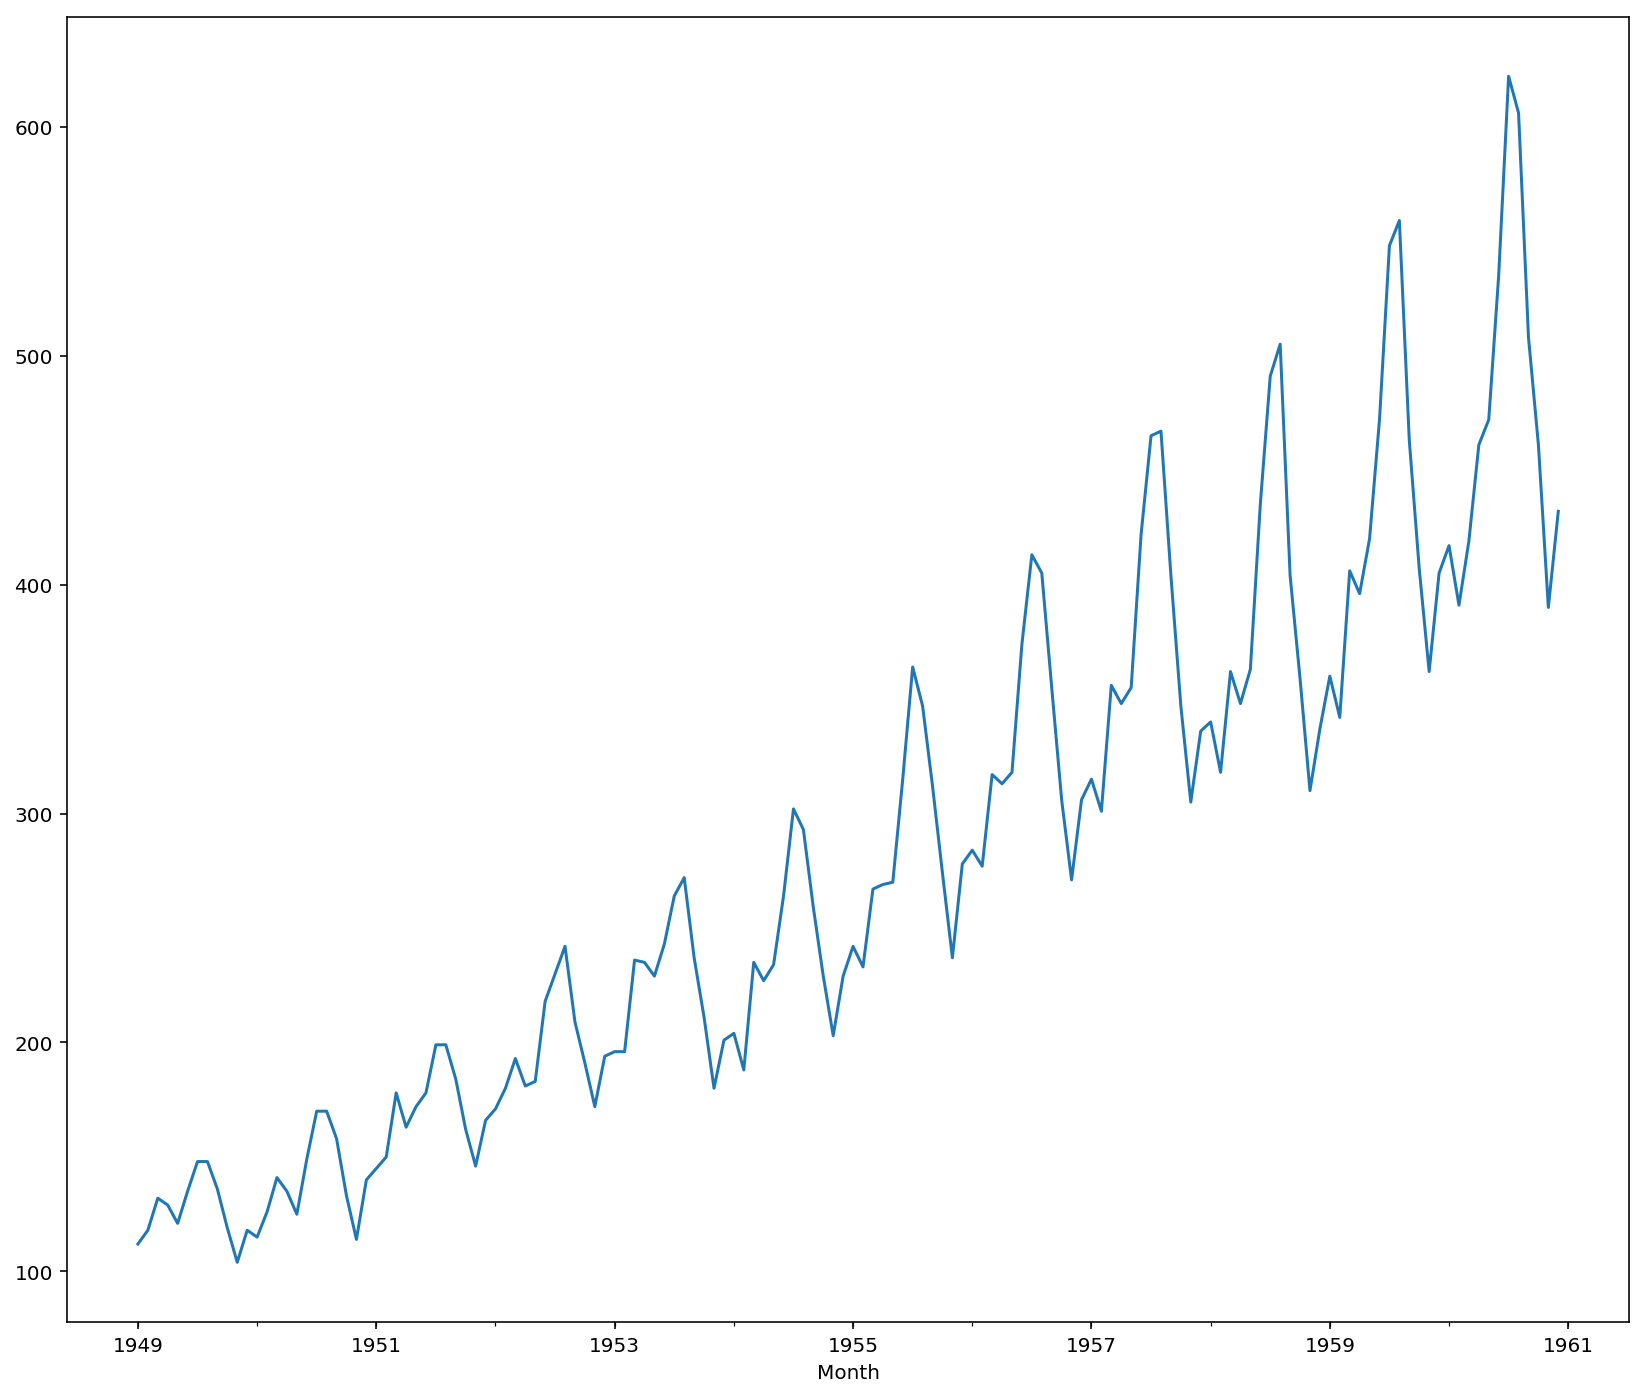

In [56]:
X_LSTM = series.copy()
X_LSTM.Passengers.plot()
X_LSTM.describe()

## Finally let's take a look at the Predicted Values

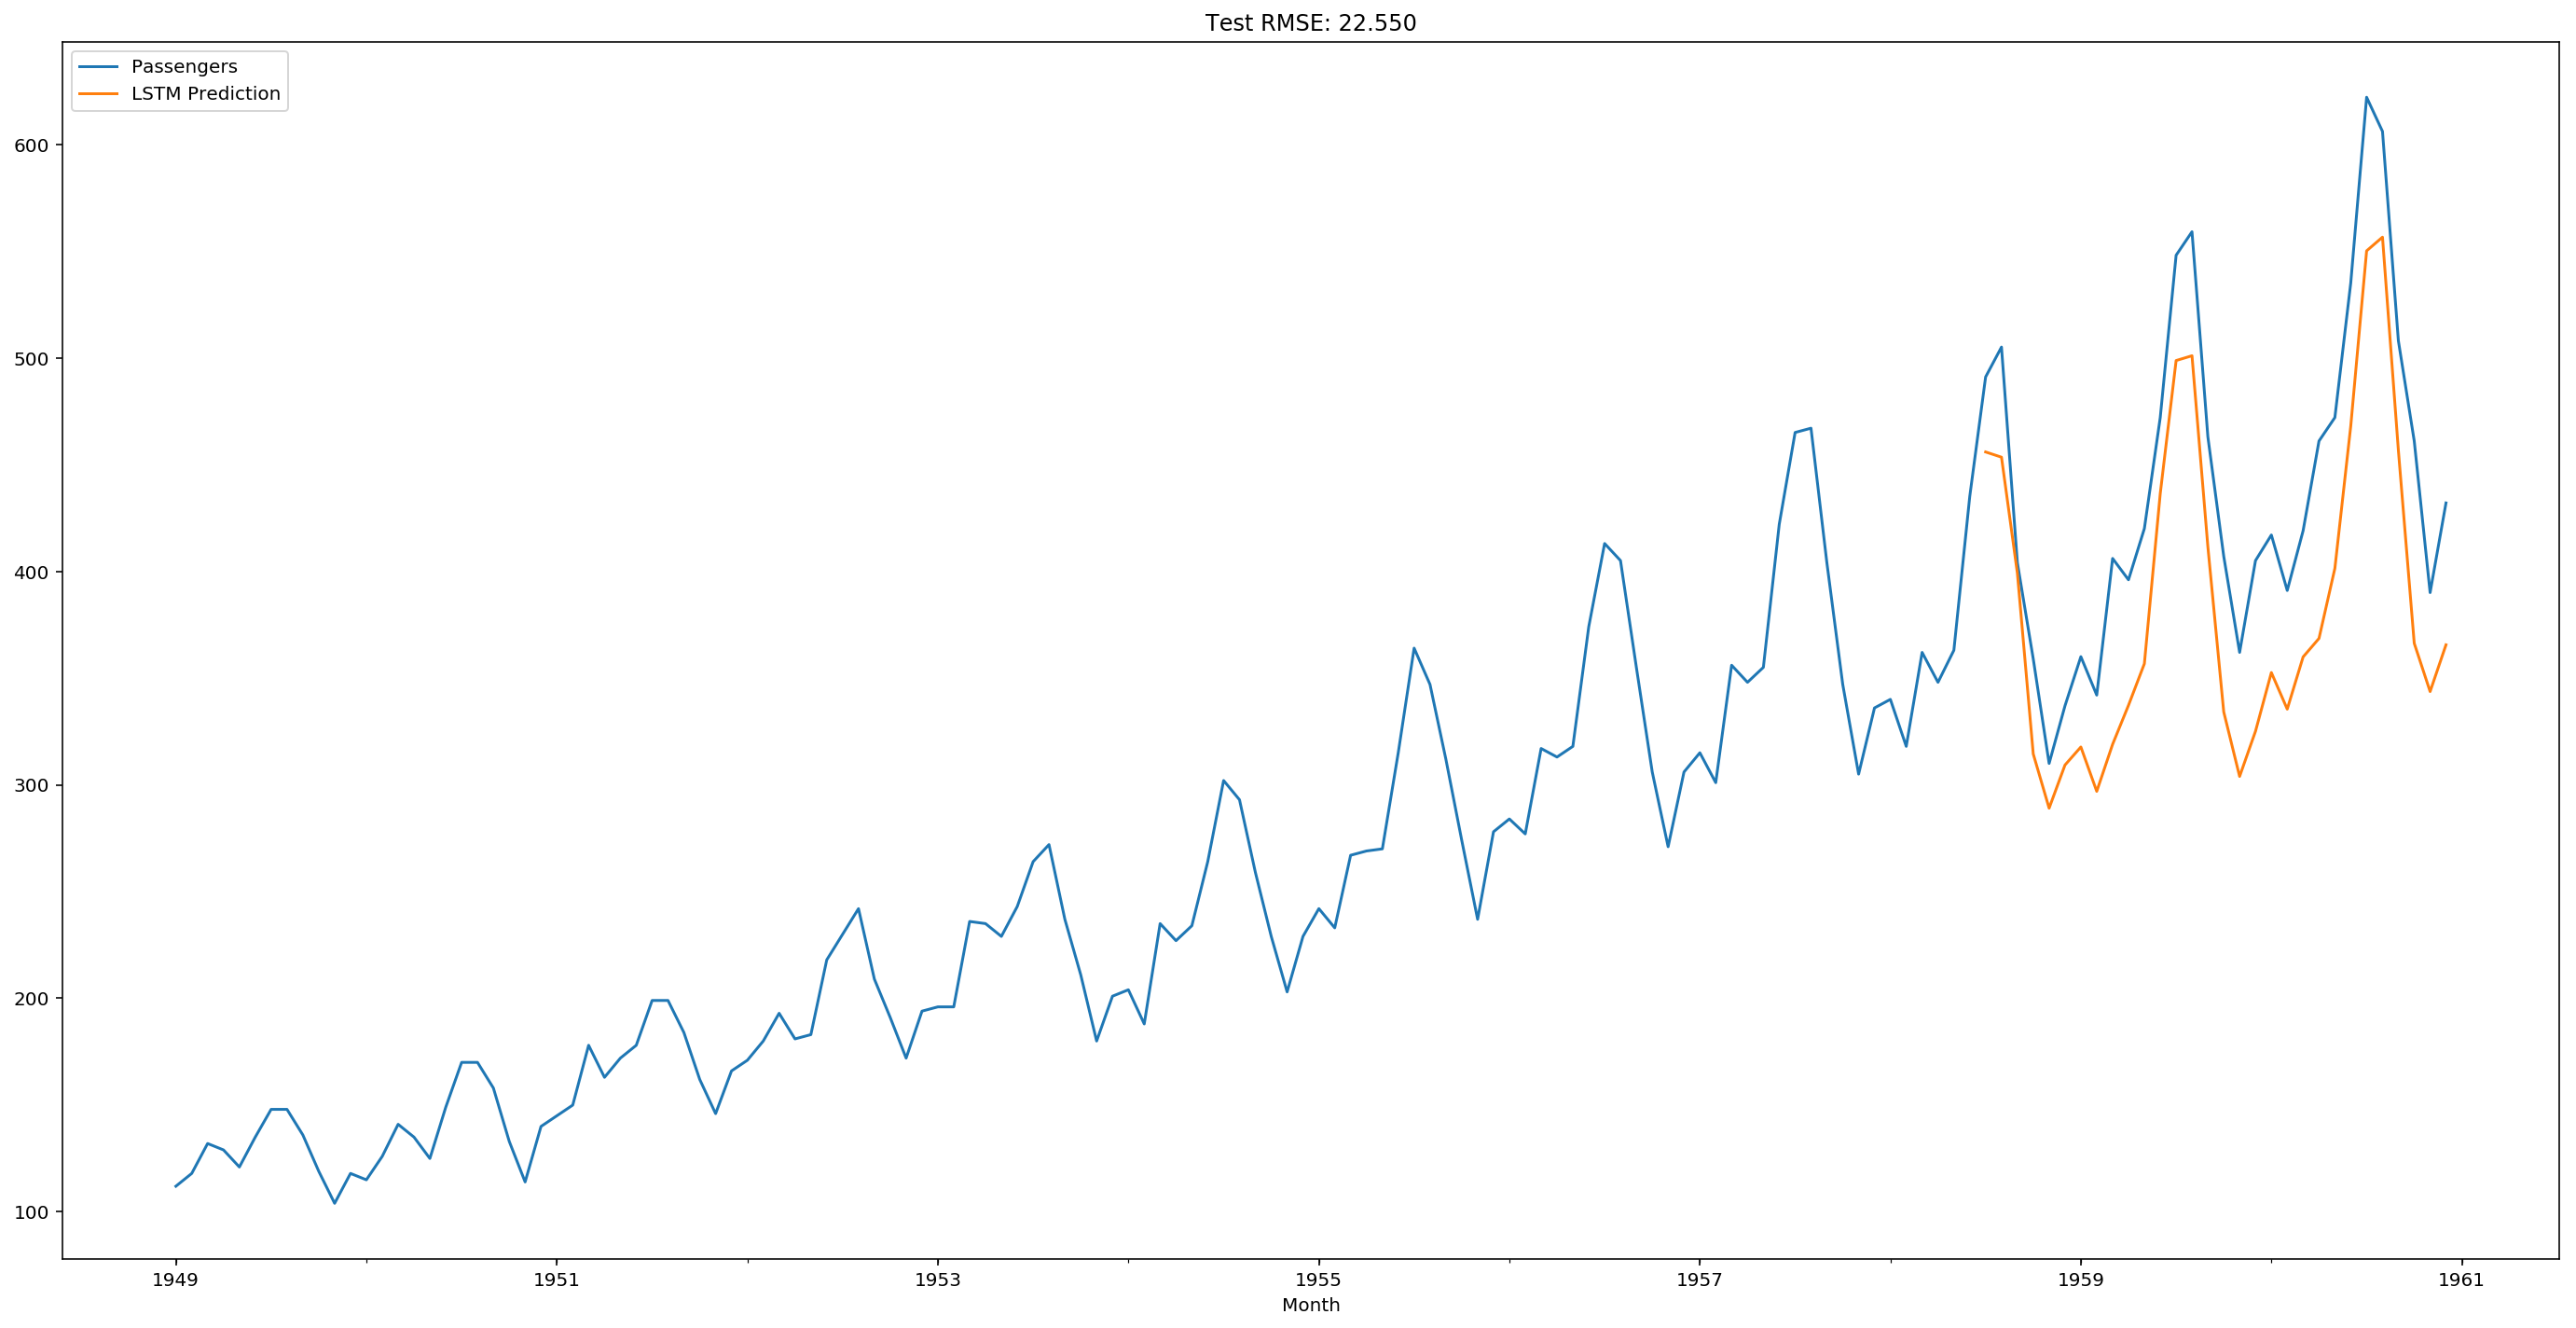

In [57]:
lstm_predictions = [np.nan for _ in range(0,114)] #add some nan's before we get to print the predicted values
X_LSTM['LSTM Prediction'] = lstm_predictions + list(inv_yhat)
X_LSTM[['Passengers','LSTM Prediction']].plot(figsize=(24,12), title=rmse_title_lstm);